In [130]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import os
import time
import seaborn as sns
import gc
%matplotlib inline
from sklearn import preprocessing, metrics, ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import metrics
import xgboost
import xgboost as xgb
import lightgbm
from xgboost import XGBClassifier, plot_importance

# Exploring the data

In [2]:
#The detailed data dictionary is mentioned here:

#ip: ip address of click.
#app: app id for marketing.
#device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
#os: os version id of user mobile phone
#channel: channel id of mobile ad publisher
#click_time: timestamp of click (UTC)
#attributed_time: if user download the app for after clicking an ad, this is the time of the app download
#is_attributed: the target that is to be predicted, indicating the action was performed


In [2]:
#Let's now understand and explore the data. Let's start with understanding the size and data types of the train_sample data.
#wanted columns
columns = ['ip', 'channel']
dtypes = {
        'ip'      : 'uint32',
        'channel' : 'uint16',
        }

ips_df_sm = pd.read_csv(r'C:\Users\jashraf\Downloads\train_sample.csv (1)/train_sample.csv', usecols=columns, dtype=dtypes)


del columns
del dtypes
gc.collect()

15

In [3]:
print(ips_df_sm.info())
print(ips_df_sm.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   ip       100000 non-null  uint32
 1   channel  100000 non-null  uint16
dtypes: uint16(1), uint32(1)
memory usage: 586.1 KB
None
       ip  channel
0   87540      497
1  105560      259
2  101424      212
3   94584      477
4   68413      178


# Data pre-processing and Feature Transformation

In [4]:
# Dividing our dataset into 4 parts we obtain 25000 rows per chunk
num_parts = 4
all_rows = len(ips_df_sm)
chunk = all_rows//num_parts
print("parts ", num_parts, "all_rows ", all_rows, "chunk", chunk)

parts  4 all_rows  100000 chunk 25000


In [5]:
for p in range(0,num_parts):
    start = p*chunk
    end = p*chunk + chunk
    if end < all_rows:
        group = ips_df_sm[start:end][['ip', 'channel']].groupby('ip', as_index=False).count()
    else:
        group = ips_df_sm[start:][['ip', 'channel']].groupby('ip', as_index=False).count()
    print(group)

           ip  channel
0           9        1
1          10        1
2          19        1
3          27        1
4          36        1
...       ...      ...
14995  363876        1
14996  363962        1
14997  364084        1
14998  364338        1
14999  364410        1

[15000 rows x 2 columns]
           ip  channel
0          10        1
1          20        2
2          27        1
3          31        1
4          59        1
...       ...      ...
15072  363710        1
15073  363962        1
15074  363995        1
15075  364168        1
15076  364471        1

[15077 rows x 2 columns]
           ip  channel
0          10        1
1          25        1
2          27        2
3          36        1
4          59        1
...       ...      ...
15081  363869        1
15082  363895        1
15083  363995        1
15084  364127        1
15085  364757        1

[15086 rows x 2 columns]
           ip  channel
0          20        2
1          27        1
2          33        1
3 

In [6]:
#sort the dataset by ip and reset the index 
ips_df_sm.sort_values(by=['ip'], inplace  = True)
ips_df_sm.reset_index(drop = True, inplace = True)
ips_df_sm.head()

,ip,channel
0,9,244
1,10,107
2,10,319
3,10,140
4,19,379


In [7]:
#calculate the most common value with the "mode", and the "window"
import operator as op
a_list = list(ips_df_sm['ip'])
most_common = int(ips_df_sm['ip'].mode())
window = op.countOf(a_list,most_common)

del a_list

gc.collect()

0

In [8]:
#function to get the unique values
def unique(list1):
    x = np.array(list1)
    return np.unique(x)

In [9]:
#set start = 0
start = 0
#new dataframe to append the results of the for loop
new_ips_df_sm=pd.DataFrame()
for p in range(0,num_parts):
    print(p)
    end = p*chunk + chunk
    print('end')
    print(end)
    if end < all_rows:
        chunk_window = ips_df_sm[start:end].tail(window+1)
        print('chunk_window')
        print(chunk_window)
        list_unique = unique(chunk_window['ip'])
        print('list_unique')
        print(list_unique)
        second_last = list_unique[-2]
        print('second_last')
        print(second_last)
        new_end = chunk_window[chunk_window['ip'] == second_last].tail(1).index.tolist()[0]
        print('new_end')
        print(new_end)
        new_chunk = ips_df_sm[start:new_end+1][['ip', 'channel']].groupby('ip', as_index=False).count()
        print('new_chunk')
        print(new_chunk)
    else:
        new_chunk = ips_df_sm[start:][['ip', 'channel']].groupby('ip', as_index=False).count()
    start = new_end+1
    new_ips_df_sm = new_ips_df_sm.append(new_chunk, ignore_index=True)
    print('step')
    print(p)
    print('new dataframe length')
    print(new_ips_df_sm.shape[0])
    
    


0
end
25000
chunk_window
          ip  channel
24330  39515      377
24331  39515      439
24332  39515      128
24333  39515      145
24334  39515      317
...      ...      ...
24995  40534      424
24996  40534      245
24997  40534      178
24998  40535      137
24999  40552      107

[670 rows x 2 columns]
list_unique
[39515 39517 39524 39546 39551 39554 39561 39596 39598 39611 39631 39639
 39651 39654 39670 39681 39684 39688 39691 39698 39711 39714 39721 39727
 39728 39729 39736 39738 39741 39742 39755 39756 39760 39762 39764 39769
 39777 39780 39782 39784 39785 39788 39790 39802 39808 39814 39818 39820
 39834 39839 39860 39861 39867 39868 39879 39884 39888 39889 39897 39903
 39922 39933 39943 39958 39965 39979 39985 40001 40005 40007 40011 40022
 40028 40038 40043 40045 40046 40052 40056 40061 40067 40074 40077 40114
 40123 40125 40133 40139 40149 40154 40157 40158 40166 40168 40169 40174
 40179 40185 40188 40190 40192 40194 40204 40205 40207 40213 40216 40221
 40228 40241 40245

C:\Users\jashraf\AppData\Local\Temp\ipykernel_11776\2419696872.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_ips_df_sm = new_ips_df_sm.append(new_chunk, ignore_index=True)
C:\Users\jashraf\AppData\Local\Temp\ipykernel_11776\2419696872.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_ips_df_sm = new_ips_df_sm.append(new_chunk, ignore_index=True)
C:\Users\jashraf\AppData\Local\Temp\ipykernel_11776\2419696872.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_ips_df_sm = new_ips_df_sm.append(new_chunk, ignore_index=True)
C:\Users\jashraf\AppData\Local\Temp\ipykernel_11776\2419696872.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

In [10]:
del ips_df_sm
del num_parts
del all_rows
del chunk
del most_common
del window
gc.collect()

0

In [11]:
print(new_ips_df_sm.info())
print(new_ips_df_sm)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ip       34857 non-null  uint32
 1   channel  34857 non-null  int64 
dtypes: int64(1), uint32(1)
memory usage: 408.6 KB
None
           ip  channel
0           9        1
1          10        3
2          19        1
3          20        4
4          25        1
...       ...      ...
34852  364515        1
34853  364621        1
34854  364630        1
34855  364648        1
34856  364757        1

[34857 rows x 2 columns]


In [12]:
#new dataframe to set actual unique IP value in new df

act_ips_df_sm = pd.DataFrame(columns=['ip','app','device','os','channel','click_time','attributed_time','is_attributed','ip_count'])
act_ips_df_sm['ip'] = act_ips_df_sm['ip'].astype('uint32')
act_ips_df_sm['app'] = act_ips_df_sm['app'].astype('uint16')
act_ips_df_sm['device'] = act_ips_df_sm['device'].astype('uint16')
act_ips_df_sm['os'] = act_ips_df_sm['os'].astype('uint16')
act_ips_df_sm['channel'] = act_ips_df_sm['channel'].astype('uint16')
act_ips_df_sm['click_time'] = act_ips_df_sm['click_time'].apply(pd.to_datetime)
act_ips_df_sm['attributed_time'] = act_ips_df_sm['attributed_time'].apply(pd.to_datetime)
act_ips_df_sm['is_attributed'] = act_ips_df_sm['is_attributed'].astype('uint16')
act_ips_df_sm['ip_count'] = act_ips_df_sm['ip_count'].astype('uint16')




In [13]:
print(act_ips_df_sm.info())
print(act_ips_df_sm)

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ip               0 non-null      uint32
 1   app              0 non-null      uint16
 2   device           0 non-null      uint16
 3   os               0 non-null      uint16
 4   channel          0 non-null      uint16
 5   click_time       0 non-null      object
 6   attributed_time  0 non-null      object
 7   is_attributed    0 non-null      uint16
 8   ip_count         0 non-null      uint16
dtypes: object(2), uint16(6), uint32(1)
memory usage: 0.0+ bytes
None
Empty DataFrame
Columns: [ip, app, device, os, channel, click_time, attributed_time, is_attributed, ip_count]
Index: []


In [2]:
#importing complete values of train_sample.csv
#wanted columns
columns = ['ip', 'app','device','os','channel','click_time','attributed_time','is_attributed']

dtypes = {
        'ip'      : 'uint32',
        'app' : 'uint16',
        'device' : 'uint16',
        'os' : 'uint16',
        'channel' : 'uint16',
        'click_time' : 'str',
        'attributed_time' : 'str',
        'is_attributed' : 'uint16',
        
    
        }

ips_df_newsm = pd.read_csv(r'C:\Users\jashraf\Downloads\train.csv~/train.csv', usecols=columns, dtype=dtypes)

del columns
del dtypes
gc.collect()

ValueError: invalid literal for int() with base 10: '1(12'

In [15]:
ips_df_newsm[["click_time", "attributed_time"]] = ips_df_newsm[["click_time", "attributed_time"]].apply(pd.to_datetime)

In [16]:
#sort the dataset by ip and reset the index 
ips_df_newsm.sort_values(by=['ip'], inplace  = True)
ips_df_newsm.reset_index(drop = True, inplace = True)
ips_df_newsm.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,9,9,1,13,244,2017-11-07 16:06:42,NaT,0
1,10,18,1,13,107,2017-11-08 11:19:15,NaT,0
2,10,11,1,22,319,2017-11-07 01:37:19,NaT,0
3,10,12,1,19,140,2017-11-07 07:33:04,NaT,0
4,19,14,1,16,379,2017-11-08 09:12:26,NaT,0


In [17]:
print(ips_df_newsm.info())
print(ips_df_newsm)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ip               100000 non-null  uint32        
 1   app              100000 non-null  uint16        
 2   device           100000 non-null  uint16        
 3   os               100000 non-null  uint16        
 4   channel          100000 non-null  uint16        
 5   click_time       100000 non-null  datetime64[ns]
 6   attributed_time  227 non-null     datetime64[ns]
 7   is_attributed    100000 non-null  uint16        
dtypes: datetime64[ns](2), uint16(5), uint32(1)
memory usage: 2.9 MB
None
           ip  app  device  os  channel          click_time attributed_time  \
0           9    9       1  13      244 2017-11-07 16:06:42             NaT   
1          10   18       1  13      107 2017-11-08 11:19:15             NaT   
2          10   11       1  22      319 

In [18]:
grp = {}
for p in range(0,10):
    grp[p] = pd.DataFrame(columns=['ip','app','device','os','channel','click_time','attributed_time','is_attributed'])
    grp[p]['ip'] = grp[p]['ip'].astype('uint32')
    grp[p]['app'] = grp[p]['app'].astype('uint16')
    grp[p]['device'] = grp[p]['device'].astype('uint16')
    grp[p]['os'] = grp[p]['os'].astype('uint16')
    grp[p]['channel'] = grp[p]['channel'].astype('uint16')
    grp[p]['click_time'] = grp[p]['click_time'].apply(pd.to_datetime)
    grp[p]['attributed_time'] = grp[p]['attributed_time'].apply(pd.to_datetime)
    grp[p]['is_attributed'] = grp[p]['is_attributed'].astype('uint16')
    
    


In [19]:

# Dividing our dataset into 10 parts we obtain 10000 rows per chunk
parts = 10
rows = len(ips_df_newsm)
row_chunk = rows//parts
print("parts ", parts, "all_rows ", rows, "chunk", row_chunk)



for p in range(0,parts):
    start = p*row_chunk
    end = p*row_chunk + row_chunk
    if end < rows:
        grp[p] = ips_df_newsm[start:end]
    else:
        grp[p] = ips_df_newsm[start:]
    print("grp[",p,"]")
    print(grp[p].info())
    print(grp[p])


parts  10 all_rows  100000 chunk 10000
grp[ 0 ]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ip               10000 non-null  uint32        
 1   app              10000 non-null  uint16        
 2   device           10000 non-null  uint16        
 3   os               10000 non-null  uint16        
 4   channel          10000 non-null  uint16        
 5   click_time       10000 non-null  datetime64[ns]
 6   attributed_time  18 non-null     datetime64[ns]
 7   is_attributed    10000 non-null  uint16        
dtypes: datetime64[ns](2), uint16(5), uint32(1)
memory usage: 293.1 KB
None
         ip  app  device  os  channel          click_time attributed_time  \
0         9    9       1  13      244 2017-11-07 16:06:42             NaT   
1        10   18       1  13      107 2017-11-08 11:19:15             NaT   
2       

In [20]:
#creating a df for start and end value of IP addresses in grp
start_end_val = pd.DataFrame(columns=['start','end'])

for q in range(0,10):
    length = grp[q].shape[0]
    start =   grp[q]['ip'].values[:1]    
    end =     grp[q]['ip'].values[length-1:length]
    start_end_val.loc[q,['start','end']] = [start[0],end[0]]
print(start_end_val)

    start     end
0       9   14737
1   14737   32575
2   32575   47948
3   47948   64346
4   64347   79827
5   79827   95688
6   95688  109845
7  109850  125934
8  125937  189970
9  189970  364757


In [21]:
#setting values of original dataset in new dataset with unique IP address
for p in range(0,new_ips_df_sm.shape[0]):
    ip  = new_ips_df_sm.iloc[p]['ip']
    ip_count  = new_ips_df_sm.iloc[p]['channel']
    print(p , '- IP: ',ip)
    
    df2=ips_df_newsm[ips_df_newsm["ip"] == ip] 
    app  = df2.iloc[0]['app']
    device  = df2.iloc[0]['device']
    os  = df2.iloc[0]['os']
    channel  = df2.iloc[0]['channel']
    click_time  = df2.iloc[0]['click_time']
    attributed_time  = df2.iloc[0]['attributed_time']
    is_attributed  = df2.iloc[0]['is_attributed']
    
    
 
    act_ips_df_sm.loc[p,['ip','app','device','os','channel','click_time','attributed_time','is_attributed','ip_count']] = [ip,app,device,os,channel,click_time,attributed_time,is_attributed,ip_count]

0 - IP:  9
1 - IP:  10
2 - IP:  19
3 - IP:  20
4 - IP:  25
5 - IP:  27
6 - IP:  31
7 - IP:  33
8 - IP:  36
9 - IP:  59
10 - IP:  63
11 - IP:  85
12 - IP:  88
13 - IP:  92
14 - IP:  95
15 - IP:  114
16 - IP:  117
17 - IP:  120
18 - IP:  122
19 - IP:  126
20 - IP:  133
21 - IP:  147
22 - IP:  165
23 - IP:  174
24 - IP:  176
25 - IP:  178
26 - IP:  196
27 - IP:  198
28 - IP:  209
29 - IP:  212
30 - IP:  219
31 - IP:  220
32 - IP:  222
33 - IP:  226
34 - IP:  234
35 - IP:  235
36 - IP:  246
37 - IP:  254
38 - IP:  255
39 - IP:  259
40 - IP:  268
41 - IP:  277
42 - IP:  279
43 - IP:  280
44 - IP:  282
45 - IP:  288
46 - IP:  301
47 - IP:  302
48 - IP:  315
49 - IP:  324
50 - IP:  341
51 - IP:  346
52 - IP:  353
53 - IP:  365
54 - IP:  368
55 - IP:  372
56 - IP:  373
57 - IP:  381
58 - IP:  391
59 - IP:  392
60 - IP:  394
61 - IP:  405
62 - IP:  407
63 - IP:  413
64 - IP:  424
65 - IP:  432
66 - IP:  436
67 - IP:  439
68 - IP:  440
69 - IP:  441
70 - IP:  444
71 - IP:  445
72 - IP:  450
73 -

560 - IP:  3219
561 - IP:  3225
562 - IP:  3239
563 - IP:  3241
564 - IP:  3247
565 - IP:  3253
566 - IP:  3262
567 - IP:  3265
568 - IP:  3266
569 - IP:  3271
570 - IP:  3279
571 - IP:  3288
572 - IP:  3289
573 - IP:  3294
574 - IP:  3307
575 - IP:  3313
576 - IP:  3314
577 - IP:  3325
578 - IP:  3332
579 - IP:  3338
580 - IP:  3339
581 - IP:  3346
582 - IP:  3350
583 - IP:  3355
584 - IP:  3359
585 - IP:  3363
586 - IP:  3376
587 - IP:  3382
588 - IP:  3403
589 - IP:  3410
590 - IP:  3425
591 - IP:  3432
592 - IP:  3435
593 - IP:  3437
594 - IP:  3442
595 - IP:  3452
596 - IP:  3453
597 - IP:  3454
598 - IP:  3461
599 - IP:  3471
600 - IP:  3472
601 - IP:  3479
602 - IP:  3481
603 - IP:  3482
604 - IP:  3488
605 - IP:  3502
606 - IP:  3505
607 - IP:  3511
608 - IP:  3513
609 - IP:  3520
610 - IP:  3542
611 - IP:  3546
612 - IP:  3553
613 - IP:  3559
614 - IP:  3564
615 - IP:  3576
616 - IP:  3582
617 - IP:  3589
618 - IP:  3591
619 - IP:  3594
620 - IP:  3611
621 - IP:  3618
622 - IP

1079 - IP:  6268
1080 - IP:  6269
1081 - IP:  6277
1082 - IP:  6282
1083 - IP:  6283
1084 - IP:  6294
1085 - IP:  6298
1086 - IP:  6306
1087 - IP:  6308
1088 - IP:  6313
1089 - IP:  6318
1090 - IP:  6319
1091 - IP:  6322
1092 - IP:  6326
1093 - IP:  6330
1094 - IP:  6331
1095 - IP:  6332
1096 - IP:  6336
1097 - IP:  6341
1098 - IP:  6351
1099 - IP:  6352
1100 - IP:  6358
1101 - IP:  6360
1102 - IP:  6367
1103 - IP:  6371
1104 - IP:  6375
1105 - IP:  6377
1106 - IP:  6380
1107 - IP:  6382
1108 - IP:  6395
1109 - IP:  6396
1110 - IP:  6410
1111 - IP:  6412
1112 - IP:  6414
1113 - IP:  6417
1114 - IP:  6424
1115 - IP:  6425
1116 - IP:  6428
1117 - IP:  6432
1118 - IP:  6437
1119 - IP:  6454
1120 - IP:  6462
1121 - IP:  6478
1122 - IP:  6479
1123 - IP:  6481
1124 - IP:  6482
1125 - IP:  6484
1126 - IP:  6486
1127 - IP:  6505
1128 - IP:  6509
1129 - IP:  6516
1130 - IP:  6517
1131 - IP:  6534
1132 - IP:  6537
1133 - IP:  6545
1134 - IP:  6547
1135 - IP:  6549
1136 - IP:  6552
1137 - IP:  65

1599 - IP:  8886
1600 - IP:  8898
1601 - IP:  8901
1602 - IP:  8911
1603 - IP:  8924
1604 - IP:  8929
1605 - IP:  8940
1606 - IP:  8943
1607 - IP:  8954
1608 - IP:  8958
1609 - IP:  8964
1610 - IP:  8968
1611 - IP:  8973
1612 - IP:  8975
1613 - IP:  8992
1614 - IP:  8994
1615 - IP:  8995
1616 - IP:  8998
1617 - IP:  9005
1618 - IP:  9015
1619 - IP:  9021
1620 - IP:  9024
1621 - IP:  9034
1622 - IP:  9038
1623 - IP:  9039
1624 - IP:  9041
1625 - IP:  9049
1626 - IP:  9050
1627 - IP:  9053
1628 - IP:  9057
1629 - IP:  9069
1630 - IP:  9071
1631 - IP:  9072
1632 - IP:  9073
1633 - IP:  9084
1634 - IP:  9087
1635 - IP:  9090
1636 - IP:  9094
1637 - IP:  9095
1638 - IP:  9096
1639 - IP:  9099
1640 - IP:  9101
1641 - IP:  9106
1642 - IP:  9113
1643 - IP:  9119
1644 - IP:  9124
1645 - IP:  9127
1646 - IP:  9130
1647 - IP:  9135
1648 - IP:  9136
1649 - IP:  9141
1650 - IP:  9142
1651 - IP:  9145
1652 - IP:  9147
1653 - IP:  9161
1654 - IP:  9169
1655 - IP:  9181
1656 - IP:  9182
1657 - IP:  91

2116 - IP:  11852
2117 - IP:  11862
2118 - IP:  11865
2119 - IP:  11869
2120 - IP:  11877
2121 - IP:  11881
2122 - IP:  11901
2123 - IP:  11902
2124 - IP:  11905
2125 - IP:  11907
2126 - IP:  11908
2127 - IP:  11911
2128 - IP:  11917
2129 - IP:  11924
2130 - IP:  11926
2131 - IP:  11938
2132 - IP:  11944
2133 - IP:  11947
2134 - IP:  11965
2135 - IP:  11967
2136 - IP:  11968
2137 - IP:  11977
2138 - IP:  11988
2139 - IP:  11997
2140 - IP:  11999
2141 - IP:  12002
2142 - IP:  12003
2143 - IP:  12031
2144 - IP:  12036
2145 - IP:  12037
2146 - IP:  12049
2147 - IP:  12053
2148 - IP:  12058
2149 - IP:  12059
2150 - IP:  12062
2151 - IP:  12076
2152 - IP:  12080
2153 - IP:  12087
2154 - IP:  12091
2155 - IP:  12103
2156 - IP:  12109
2157 - IP:  12118
2158 - IP:  12129
2159 - IP:  12131
2160 - IP:  12134
2161 - IP:  12140
2162 - IP:  12144
2163 - IP:  12148
2164 - IP:  12164
2165 - IP:  12167
2166 - IP:  12171
2167 - IP:  12182
2168 - IP:  12187
2169 - IP:  12188
2170 - IP:  12207
2171 - IP:

2592 - IP:  14874
2593 - IP:  14877
2594 - IP:  14878
2595 - IP:  14884
2596 - IP:  14888
2597 - IP:  14893
2598 - IP:  14895
2599 - IP:  14897
2600 - IP:  14903
2601 - IP:  14910
2602 - IP:  14913
2603 - IP:  14915
2604 - IP:  14918
2605 - IP:  14921
2606 - IP:  14922
2607 - IP:  14925
2608 - IP:  14926
2609 - IP:  14932
2610 - IP:  14939
2611 - IP:  14945
2612 - IP:  14947
2613 - IP:  14950
2614 - IP:  14955
2615 - IP:  14966
2616 - IP:  14967
2617 - IP:  14970
2618 - IP:  14972
2619 - IP:  14977
2620 - IP:  14990
2621 - IP:  14999
2622 - IP:  15000
2623 - IP:  15010
2624 - IP:  15019
2625 - IP:  15026
2626 - IP:  15027
2627 - IP:  15030
2628 - IP:  15034
2629 - IP:  15035
2630 - IP:  15046
2631 - IP:  15049
2632 - IP:  15053
2633 - IP:  15059
2634 - IP:  15075
2635 - IP:  15080
2636 - IP:  15092
2637 - IP:  15109
2638 - IP:  15111
2639 - IP:  15114
2640 - IP:  15117
2641 - IP:  15118
2642 - IP:  15136
2643 - IP:  15143
2644 - IP:  15148
2645 - IP:  15150
2646 - IP:  15168
2647 - IP:

3049 - IP:  17452
3050 - IP:  17458
3051 - IP:  17459
3052 - IP:  17460
3053 - IP:  17461
3054 - IP:  17462
3055 - IP:  17477
3056 - IP:  17481
3057 - IP:  17485
3058 - IP:  17486
3059 - IP:  17491
3060 - IP:  17505
3061 - IP:  17511
3062 - IP:  17513
3063 - IP:  17521
3064 - IP:  17527
3065 - IP:  17537
3066 - IP:  17538
3067 - IP:  17545
3068 - IP:  17549
3069 - IP:  17551
3070 - IP:  17552
3071 - IP:  17560
3072 - IP:  17563
3073 - IP:  17572
3074 - IP:  17587
3075 - IP:  17589
3076 - IP:  17593
3077 - IP:  17600
3078 - IP:  17602
3079 - IP:  17609
3080 - IP:  17610
3081 - IP:  17623
3082 - IP:  17626
3083 - IP:  17629
3084 - IP:  17635
3085 - IP:  17647
3086 - IP:  17655
3087 - IP:  17663
3088 - IP:  17672
3089 - IP:  17677
3090 - IP:  17686
3091 - IP:  17703
3092 - IP:  17716
3093 - IP:  17717
3094 - IP:  17725
3095 - IP:  17728
3096 - IP:  17730
3097 - IP:  17739
3098 - IP:  17740
3099 - IP:  17741
3100 - IP:  17747
3101 - IP:  17749
3102 - IP:  17751
3103 - IP:  17756
3104 - IP:

3544 - IP:  20153
3545 - IP:  20155
3546 - IP:  20162
3547 - IP:  20165
3548 - IP:  20173
3549 - IP:  20184
3550 - IP:  20188
3551 - IP:  20204
3552 - IP:  20211
3553 - IP:  20214
3554 - IP:  20215
3555 - IP:  20229
3556 - IP:  20236
3557 - IP:  20240
3558 - IP:  20241
3559 - IP:  20242
3560 - IP:  20253
3561 - IP:  20262
3562 - IP:  20264
3563 - IP:  20265
3564 - IP:  20266
3565 - IP:  20294
3566 - IP:  20295
3567 - IP:  20296
3568 - IP:  20297
3569 - IP:  20303
3570 - IP:  20309
3571 - IP:  20322
3572 - IP:  20326
3573 - IP:  20327
3574 - IP:  20340
3575 - IP:  20357
3576 - IP:  20361
3577 - IP:  20362
3578 - IP:  20376
3579 - IP:  20385
3580 - IP:  20387
3581 - IP:  20391
3582 - IP:  20393
3583 - IP:  20398
3584 - IP:  20407
3585 - IP:  20411
3586 - IP:  20414
3587 - IP:  20415
3588 - IP:  20422
3589 - IP:  20428
3590 - IP:  20429
3591 - IP:  20438
3592 - IP:  20449
3593 - IP:  20450
3594 - IP:  20454
3595 - IP:  20465
3596 - IP:  20473
3597 - IP:  20474
3598 - IP:  20482
3599 - IP:

4011 - IP:  23149
4012 - IP:  23155
4013 - IP:  23157
4014 - IP:  23167
4015 - IP:  23182
4016 - IP:  23183
4017 - IP:  23184
4018 - IP:  23192
4019 - IP:  23199
4020 - IP:  23203
4021 - IP:  23207
4022 - IP:  23217
4023 - IP:  23219
4024 - IP:  23225
4025 - IP:  23229
4026 - IP:  23233
4027 - IP:  23242
4028 - IP:  23246
4029 - IP:  23248
4030 - IP:  23260
4031 - IP:  23269
4032 - IP:  23270
4033 - IP:  23271
4034 - IP:  23286
4035 - IP:  23289
4036 - IP:  23290
4037 - IP:  23294
4038 - IP:  23306
4039 - IP:  23313
4040 - IP:  23316
4041 - IP:  23319
4042 - IP:  23320
4043 - IP:  23322
4044 - IP:  23334
4045 - IP:  23342
4046 - IP:  23358
4047 - IP:  23361
4048 - IP:  23370
4049 - IP:  23375
4050 - IP:  23378
4051 - IP:  23386
4052 - IP:  23391
4053 - IP:  23395
4054 - IP:  23398
4055 - IP:  23402
4056 - IP:  23411
4057 - IP:  23413
4058 - IP:  23432
4059 - IP:  23434
4060 - IP:  23439
4061 - IP:  23445
4062 - IP:  23450
4063 - IP:  23451
4064 - IP:  23453
4065 - IP:  23466
4066 - IP:

4468 - IP:  26093
4469 - IP:  26101
4470 - IP:  26107
4471 - IP:  26119
4472 - IP:  26129
4473 - IP:  26130
4474 - IP:  26147
4475 - IP:  26156
4476 - IP:  26160
4477 - IP:  26177
4478 - IP:  26184
4479 - IP:  26190
4480 - IP:  26208
4481 - IP:  26215
4482 - IP:  26218
4483 - IP:  26233
4484 - IP:  26238
4485 - IP:  26241
4486 - IP:  26246
4487 - IP:  26259
4488 - IP:  26261
4489 - IP:  26263
4490 - IP:  26264
4491 - IP:  26279
4492 - IP:  26280
4493 - IP:  26285
4494 - IP:  26292
4495 - IP:  26298
4496 - IP:  26302
4497 - IP:  26310
4498 - IP:  26315
4499 - IP:  26318
4500 - IP:  26328
4501 - IP:  26332
4502 - IP:  26337
4503 - IP:  26340
4504 - IP:  26343
4505 - IP:  26346
4506 - IP:  26349
4507 - IP:  26350
4508 - IP:  26361
4509 - IP:  26363
4510 - IP:  26367
4511 - IP:  26372
4512 - IP:  26375
4513 - IP:  26379
4514 - IP:  26381
4515 - IP:  26382
4516 - IP:  26385
4517 - IP:  26388
4518 - IP:  26390
4519 - IP:  26391
4520 - IP:  26400
4521 - IP:  26402
4522 - IP:  26406
4523 - IP:

4966 - IP:  28801
4967 - IP:  28814
4968 - IP:  28823
4969 - IP:  28842
4970 - IP:  28852
4971 - IP:  28910
4972 - IP:  28923
4973 - IP:  28938
4974 - IP:  28943
4975 - IP:  28945
4976 - IP:  28950
4977 - IP:  28951
4978 - IP:  28956
4979 - IP:  28959
4980 - IP:  28960
4981 - IP:  28963
4982 - IP:  28970
4983 - IP:  28974
4984 - IP:  28976
4985 - IP:  28977
4986 - IP:  28982
4987 - IP:  28986
4988 - IP:  28998
4989 - IP:  29001
4990 - IP:  29002
4991 - IP:  29012
4992 - IP:  29016
4993 - IP:  29024
4994 - IP:  29025
4995 - IP:  29029
4996 - IP:  29031
4997 - IP:  29034
4998 - IP:  29036
4999 - IP:  29037
5000 - IP:  29042
5001 - IP:  29045
5002 - IP:  29047
5003 - IP:  29058
5004 - IP:  29063
5005 - IP:  29066
5006 - IP:  29069
5007 - IP:  29070
5008 - IP:  29072
5009 - IP:  29078
5010 - IP:  29085
5011 - IP:  29086
5012 - IP:  29098
5013 - IP:  29101
5014 - IP:  29107
5015 - IP:  29114
5016 - IP:  29118
5017 - IP:  29126
5018 - IP:  29128
5019 - IP:  29135
5020 - IP:  29140
5021 - IP:

5425 - IP:  31536
5426 - IP:  31539
5427 - IP:  31542
5428 - IP:  31543
5429 - IP:  31544
5430 - IP:  31545
5431 - IP:  31555
5432 - IP:  31558
5433 - IP:  31560
5434 - IP:  31564
5435 - IP:  31572
5436 - IP:  31573
5437 - IP:  31580
5438 - IP:  31582
5439 - IP:  31590
5440 - IP:  31597
5441 - IP:  31603
5442 - IP:  31616
5443 - IP:  31624
5444 - IP:  31643
5445 - IP:  31652
5446 - IP:  31653
5447 - IP:  31667
5448 - IP:  31672
5449 - IP:  31675
5450 - IP:  31678
5451 - IP:  31687
5452 - IP:  31695
5453 - IP:  31697
5454 - IP:  31702
5455 - IP:  31709
5456 - IP:  31722
5457 - IP:  31723
5458 - IP:  31724
5459 - IP:  31725
5460 - IP:  31730
5461 - IP:  31731
5462 - IP:  31732
5463 - IP:  31736
5464 - IP:  31737
5465 - IP:  31752
5466 - IP:  31768
5467 - IP:  31773
5468 - IP:  31778
5469 - IP:  31783
5470 - IP:  31784
5471 - IP:  31785
5472 - IP:  31787
5473 - IP:  31790
5474 - IP:  31810
5475 - IP:  31813
5476 - IP:  31815
5477 - IP:  31816
5478 - IP:  31817
5479 - IP:  31823
5480 - IP:

5911 - IP:  34216
5912 - IP:  34217
5913 - IP:  34222
5914 - IP:  34223
5915 - IP:  34225
5916 - IP:  34240
5917 - IP:  34243
5918 - IP:  34245
5919 - IP:  34252
5920 - IP:  34253
5921 - IP:  34254
5922 - IP:  34269
5923 - IP:  34273
5924 - IP:  34284
5925 - IP:  34287
5926 - IP:  34292
5927 - IP:  34295
5928 - IP:  34304
5929 - IP:  34311
5930 - IP:  34318
5931 - IP:  34321
5932 - IP:  34323
5933 - IP:  34325
5934 - IP:  34331
5935 - IP:  34337
5936 - IP:  34342
5937 - IP:  34352
5938 - IP:  34353
5939 - IP:  34366
5940 - IP:  34378
5941 - IP:  34380
5942 - IP:  34385
5943 - IP:  34387
5944 - IP:  34388
5945 - IP:  34393
5946 - IP:  34396
5947 - IP:  34399
5948 - IP:  34401
5949 - IP:  34402
5950 - IP:  34406
5951 - IP:  34409
5952 - IP:  34412
5953 - IP:  34419
5954 - IP:  34431
5955 - IP:  34432
5956 - IP:  34450
5957 - IP:  34456
5958 - IP:  34457
5959 - IP:  34459
5960 - IP:  34461
5961 - IP:  34463
5962 - IP:  34472
5963 - IP:  34475
5964 - IP:  34482
5965 - IP:  34486
5966 - IP:

6407 - IP:  37113
6408 - IP:  37120
6409 - IP:  37124
6410 - IP:  37135
6411 - IP:  37140
6412 - IP:  37142
6413 - IP:  37143
6414 - IP:  37145
6415 - IP:  37148
6416 - IP:  37150
6417 - IP:  37158
6418 - IP:  37161
6419 - IP:  37162
6420 - IP:  37167
6421 - IP:  37168
6422 - IP:  37173
6423 - IP:  37177
6424 - IP:  37179
6425 - IP:  37180
6426 - IP:  37183
6427 - IP:  37185
6428 - IP:  37186
6429 - IP:  37190
6430 - IP:  37193
6431 - IP:  37197
6432 - IP:  37207
6433 - IP:  37215
6434 - IP:  37217
6435 - IP:  37218
6436 - IP:  37220
6437 - IP:  37233
6438 - IP:  37234
6439 - IP:  37237
6440 - IP:  37240
6441 - IP:  37241
6442 - IP:  37243
6443 - IP:  37249
6444 - IP:  37252
6445 - IP:  37253
6446 - IP:  37255
6447 - IP:  37262
6448 - IP:  37264
6449 - IP:  37269
6450 - IP:  37273
6451 - IP:  37277
6452 - IP:  37280
6453 - IP:  37283
6454 - IP:  37287
6455 - IP:  37293
6456 - IP:  37294
6457 - IP:  37295
6458 - IP:  37301
6459 - IP:  37309
6460 - IP:  37318
6461 - IP:  37320
6462 - IP:

6872 - IP:  39430
6873 - IP:  39436
6874 - IP:  39447
6875 - IP:  39448
6876 - IP:  39451
6877 - IP:  39453
6878 - IP:  39454
6879 - IP:  39455
6880 - IP:  39459
6881 - IP:  39464
6882 - IP:  39465
6883 - IP:  39474
6884 - IP:  39479
6885 - IP:  39480
6886 - IP:  39493
6887 - IP:  39495
6888 - IP:  39505
6889 - IP:  39515
6890 - IP:  39517
6891 - IP:  39524
6892 - IP:  39546
6893 - IP:  39551
6894 - IP:  39554
6895 - IP:  39561
6896 - IP:  39596
6897 - IP:  39598
6898 - IP:  39611
6899 - IP:  39631
6900 - IP:  39639
6901 - IP:  39651
6902 - IP:  39654
6903 - IP:  39670
6904 - IP:  39681
6905 - IP:  39684
6906 - IP:  39688
6907 - IP:  39691
6908 - IP:  39698
6909 - IP:  39711
6910 - IP:  39714
6911 - IP:  39721
6912 - IP:  39727
6913 - IP:  39728
6914 - IP:  39729
6915 - IP:  39736
6916 - IP:  39738
6917 - IP:  39741
6918 - IP:  39742
6919 - IP:  39755
6920 - IP:  39756
6921 - IP:  39760
6922 - IP:  39762
6923 - IP:  39764
6924 - IP:  39769
6925 - IP:  39777
6926 - IP:  39780
6927 - IP:

7331 - IP:  42164
7332 - IP:  42167
7333 - IP:  42171
7334 - IP:  42176
7335 - IP:  42177
7336 - IP:  42180
7337 - IP:  42186
7338 - IP:  42190
7339 - IP:  42191
7340 - IP:  42192
7341 - IP:  42197
7342 - IP:  42201
7343 - IP:  42207
7344 - IP:  42208
7345 - IP:  42215
7346 - IP:  42216
7347 - IP:  42219
7348 - IP:  42220
7349 - IP:  42237
7350 - IP:  42240
7351 - IP:  42242
7352 - IP:  42243
7353 - IP:  42248
7354 - IP:  42250
7355 - IP:  42251
7356 - IP:  42252
7357 - IP:  42254
7358 - IP:  42255
7359 - IP:  42262
7360 - IP:  42266
7361 - IP:  42269
7362 - IP:  42270
7363 - IP:  42271
7364 - IP:  42278
7365 - IP:  42280
7366 - IP:  42283
7367 - IP:  42285
7368 - IP:  42289
7369 - IP:  42294
7370 - IP:  42297
7371 - IP:  42298
7372 - IP:  42299
7373 - IP:  42301
7374 - IP:  42306
7375 - IP:  42307
7376 - IP:  42311
7377 - IP:  42313
7378 - IP:  42327
7379 - IP:  42333
7380 - IP:  42334
7381 - IP:  42354
7382 - IP:  42360
7383 - IP:  42363
7384 - IP:  42369
7385 - IP:  42371
7386 - IP:

7826 - IP:  44912
7827 - IP:  44919
7828 - IP:  44926
7829 - IP:  44932
7830 - IP:  44951
7831 - IP:  44952
7832 - IP:  44957
7833 - IP:  44960
7834 - IP:  44961
7835 - IP:  44980
7836 - IP:  44982
7837 - IP:  45004
7838 - IP:  45009
7839 - IP:  45015
7840 - IP:  45018
7841 - IP:  45021
7842 - IP:  45023
7843 - IP:  45029
7844 - IP:  45041
7845 - IP:  45047
7846 - IP:  45054
7847 - IP:  45055
7848 - IP:  45061
7849 - IP:  45070
7850 - IP:  45073
7851 - IP:  45083
7852 - IP:  45088
7853 - IP:  45105
7854 - IP:  45110
7855 - IP:  45117
7856 - IP:  45121
7857 - IP:  45137
7858 - IP:  45140
7859 - IP:  45142
7860 - IP:  45143
7861 - IP:  45157
7862 - IP:  45159
7863 - IP:  45163
7864 - IP:  45167
7865 - IP:  45169
7866 - IP:  45181
7867 - IP:  45184
7868 - IP:  45192
7869 - IP:  45193
7870 - IP:  45213
7871 - IP:  45214
7872 - IP:  45227
7873 - IP:  45236
7874 - IP:  45242
7875 - IP:  45243
7876 - IP:  45248
7877 - IP:  45256
7878 - IP:  45257
7879 - IP:  45261
7880 - IP:  45265
7881 - IP:

8294 - IP:  47505
8295 - IP:  47517
8296 - IP:  47523
8297 - IP:  47534
8298 - IP:  47543
8299 - IP:  47549
8300 - IP:  47552
8301 - IP:  47554
8302 - IP:  47567
8303 - IP:  47577
8304 - IP:  47581
8305 - IP:  47592
8306 - IP:  47598
8307 - IP:  47602
8308 - IP:  47607
8309 - IP:  47611
8310 - IP:  47617
8311 - IP:  47618
8312 - IP:  47625
8313 - IP:  47630
8314 - IP:  47633
8315 - IP:  47648
8316 - IP:  47649
8317 - IP:  47658
8318 - IP:  47661
8319 - IP:  47664
8320 - IP:  47669
8321 - IP:  47674
8322 - IP:  47682
8323 - IP:  47689
8324 - IP:  47696
8325 - IP:  47697
8326 - IP:  47699
8327 - IP:  47704
8328 - IP:  47708
8329 - IP:  47717
8330 - IP:  47720
8331 - IP:  47727
8332 - IP:  47728
8333 - IP:  47730
8334 - IP:  47739
8335 - IP:  47744
8336 - IP:  47747
8337 - IP:  47748
8338 - IP:  47759
8339 - IP:  47770
8340 - IP:  47772
8341 - IP:  47773
8342 - IP:  47776
8343 - IP:  47793
8344 - IP:  47800
8345 - IP:  47802
8346 - IP:  47810
8347 - IP:  47825
8348 - IP:  47829
8349 - IP:

8762 - IP:  49693
8763 - IP:  49694
8764 - IP:  49696
8765 - IP:  49707
8766 - IP:  49721
8767 - IP:  49729
8768 - IP:  49740
8769 - IP:  49747
8770 - IP:  49749
8771 - IP:  49754
8772 - IP:  49767
8773 - IP:  49768
8774 - IP:  49774
8775 - IP:  49783
8776 - IP:  49791
8777 - IP:  49793
8778 - IP:  49803
8779 - IP:  49808
8780 - IP:  49818
8781 - IP:  49819
8782 - IP:  49823
8783 - IP:  49824
8784 - IP:  49843
8785 - IP:  49850
8786 - IP:  49851
8787 - IP:  49855
8788 - IP:  49856
8789 - IP:  49858
8790 - IP:  49876
8791 - IP:  49882
8792 - IP:  49887
8793 - IP:  49901
8794 - IP:  49909
8795 - IP:  49913
8796 - IP:  49914
8797 - IP:  49916
8798 - IP:  49920
8799 - IP:  49921
8800 - IP:  49938
8801 - IP:  49939
8802 - IP:  49963
8803 - IP:  49966
8804 - IP:  49969
8805 - IP:  49973
8806 - IP:  49996
8807 - IP:  49997
8808 - IP:  50004
8809 - IP:  50006
8810 - IP:  50011
8811 - IP:  50027
8812 - IP:  50033
8813 - IP:  50037
8814 - IP:  50055
8815 - IP:  50058
8816 - IP:  50062
8817 - IP:

9254 - IP:  52669
9255 - IP:  52670
9256 - IP:  52672
9257 - IP:  52673
9258 - IP:  52676
9259 - IP:  52678
9260 - IP:  52679
9261 - IP:  52682
9262 - IP:  52691
9263 - IP:  52692
9264 - IP:  52695
9265 - IP:  52701
9266 - IP:  52706
9267 - IP:  52710
9268 - IP:  52712
9269 - IP:  52717
9270 - IP:  52718
9271 - IP:  52722
9272 - IP:  52726
9273 - IP:  52738
9274 - IP:  52746
9275 - IP:  52747
9276 - IP:  52750
9277 - IP:  52752
9278 - IP:  52766
9279 - IP:  52767
9280 - IP:  52780
9281 - IP:  52786
9282 - IP:  52791
9283 - IP:  52798
9284 - IP:  52805
9285 - IP:  52810
9286 - IP:  52818
9287 - IP:  52830
9288 - IP:  52840
9289 - IP:  52844
9290 - IP:  52847
9291 - IP:  52853
9292 - IP:  52855
9293 - IP:  52857
9294 - IP:  52859
9295 - IP:  52862
9296 - IP:  52878
9297 - IP:  52879
9298 - IP:  52881
9299 - IP:  52883
9300 - IP:  52886
9301 - IP:  52900
9302 - IP:  52905
9303 - IP:  52920
9304 - IP:  52923
9305 - IP:  52924
9306 - IP:  52933
9307 - IP:  52938
9308 - IP:  52948
9309 - IP:

9712 - IP:  55477
9713 - IP:  55486
9714 - IP:  55487
9715 - IP:  55492
9716 - IP:  55504
9717 - IP:  55516
9718 - IP:  55547
9719 - IP:  55562
9720 - IP:  55566
9721 - IP:  55567
9722 - IP:  55569
9723 - IP:  55570
9724 - IP:  55575
9725 - IP:  55580
9726 - IP:  55586
9727 - IP:  55588
9728 - IP:  55589
9729 - IP:  55595
9730 - IP:  55614
9731 - IP:  55615
9732 - IP:  55625
9733 - IP:  55641
9734 - IP:  55642
9735 - IP:  55645
9736 - IP:  55649
9737 - IP:  55657
9738 - IP:  55661
9739 - IP:  55662
9740 - IP:  55666
9741 - IP:  55675
9742 - IP:  55684
9743 - IP:  55685
9744 - IP:  55690
9745 - IP:  55693
9746 - IP:  55694
9747 - IP:  55695
9748 - IP:  55705
9749 - IP:  55707
9750 - IP:  55713
9751 - IP:  55722
9752 - IP:  55725
9753 - IP:  55726
9754 - IP:  55727
9755 - IP:  55729
9756 - IP:  55739
9757 - IP:  55742
9758 - IP:  55745
9759 - IP:  55771
9760 - IP:  55773
9761 - IP:  55774
9762 - IP:  55776
9763 - IP:  55786
9764 - IP:  55791
9765 - IP:  55796
9766 - IP:  55800
9767 - IP:

10166 - IP:  58250
10167 - IP:  58252
10168 - IP:  58254
10169 - IP:  58264
10170 - IP:  58280
10171 - IP:  58281
10172 - IP:  58284
10173 - IP:  58287
10174 - IP:  58288
10175 - IP:  58292
10176 - IP:  58308
10177 - IP:  58316
10178 - IP:  58318
10179 - IP:  58321
10180 - IP:  58324
10181 - IP:  58325
10182 - IP:  58334
10183 - IP:  58346
10184 - IP:  58357
10185 - IP:  58363
10186 - IP:  58369
10187 - IP:  58375
10188 - IP:  58382
10189 - IP:  58383
10190 - IP:  58404
10191 - IP:  58410
10192 - IP:  58415
10193 - IP:  58420
10194 - IP:  58425
10195 - IP:  58431
10196 - IP:  58432
10197 - IP:  58434
10198 - IP:  58442
10199 - IP:  58444
10200 - IP:  58453
10201 - IP:  58463
10202 - IP:  58466
10203 - IP:  58472
10204 - IP:  58473
10205 - IP:  58474
10206 - IP:  58476
10207 - IP:  58482
10208 - IP:  58485
10209 - IP:  58489
10210 - IP:  58493
10211 - IP:  58500
10212 - IP:  58506
10213 - IP:  58514
10214 - IP:  58515
10215 - IP:  58524
10216 - IP:  58529
10217 - IP:  58535
10218 - IP: 

10607 - IP:  60812
10608 - IP:  60815
10609 - IP:  60847
10610 - IP:  60850
10611 - IP:  60854
10612 - IP:  60860
10613 - IP:  60861
10614 - IP:  60862
10615 - IP:  60869
10616 - IP:  60875
10617 - IP:  60877
10618 - IP:  60878
10619 - IP:  60884
10620 - IP:  60893
10621 - IP:  60901
10622 - IP:  60903
10623 - IP:  60909
10624 - IP:  60913
10625 - IP:  60916
10626 - IP:  60920
10627 - IP:  60924
10628 - IP:  60925
10629 - IP:  60937
10630 - IP:  60941
10631 - IP:  60945
10632 - IP:  60955
10633 - IP:  60966
10634 - IP:  60972
10635 - IP:  60979
10636 - IP:  60984
10637 - IP:  60985
10638 - IP:  60990
10639 - IP:  61001
10640 - IP:  61009
10641 - IP:  61015
10642 - IP:  61038
10643 - IP:  61048
10644 - IP:  61049
10645 - IP:  61056
10646 - IP:  61059
10647 - IP:  61061
10648 - IP:  61066
10649 - IP:  61081
10650 - IP:  61082
10651 - IP:  61088
10652 - IP:  61092
10653 - IP:  61105
10654 - IP:  61106
10655 - IP:  61108
10656 - IP:  61132
10657 - IP:  61135
10658 - IP:  61136
10659 - IP: 

11050 - IP:  63659
11051 - IP:  63666
11052 - IP:  63671
11053 - IP:  63680
11054 - IP:  63685
11055 - IP:  63692
11056 - IP:  63698
11057 - IP:  63701
11058 - IP:  63707
11059 - IP:  63712
11060 - IP:  63713
11061 - IP:  63715
11062 - IP:  63724
11063 - IP:  63725
11064 - IP:  63733
11065 - IP:  63745
11066 - IP:  63748
11067 - IP:  63750
11068 - IP:  63753
11069 - IP:  63760
11070 - IP:  63761
11071 - IP:  63762
11072 - IP:  63776
11073 - IP:  63778
11074 - IP:  63787
11075 - IP:  63790
11076 - IP:  63793
11077 - IP:  63798
11078 - IP:  63804
11079 - IP:  63812
11080 - IP:  63815
11081 - IP:  63817
11082 - IP:  63819
11083 - IP:  63822
11084 - IP:  63829
11085 - IP:  63832
11086 - IP:  63839
11087 - IP:  63840
11088 - IP:  63842
11089 - IP:  63848
11090 - IP:  63862
11091 - IP:  63870
11092 - IP:  63872
11093 - IP:  63878
11094 - IP:  63881
11095 - IP:  63883
11096 - IP:  63890
11097 - IP:  63902
11098 - IP:  63913
11099 - IP:  63914
11100 - IP:  63918
11101 - IP:  63925
11102 - IP: 

11514 - IP:  66479
11515 - IP:  66480
11516 - IP:  66485
11517 - IP:  66489
11518 - IP:  66500
11519 - IP:  66505
11520 - IP:  66506
11521 - IP:  66507
11522 - IP:  66510
11523 - IP:  66515
11524 - IP:  66518
11525 - IP:  66519
11526 - IP:  66520
11527 - IP:  66525
11528 - IP:  66541
11529 - IP:  66544
11530 - IP:  66551
11531 - IP:  66552
11532 - IP:  66556
11533 - IP:  66560
11534 - IP:  66564
11535 - IP:  66570
11536 - IP:  66571
11537 - IP:  66573
11538 - IP:  66576
11539 - IP:  66587
11540 - IP:  66592
11541 - IP:  66593
11542 - IP:  66594
11543 - IP:  66595
11544 - IP:  66596
11545 - IP:  66599
11546 - IP:  66602
11547 - IP:  66604
11548 - IP:  66614
11549 - IP:  66623
11550 - IP:  66626
11551 - IP:  66629
11552 - IP:  66633
11553 - IP:  66634
11554 - IP:  66638
11555 - IP:  66643
11556 - IP:  66644
11557 - IP:  66658
11558 - IP:  66660
11559 - IP:  66665
11560 - IP:  66671
11561 - IP:  66677
11562 - IP:  66679
11563 - IP:  66682
11564 - IP:  66686
11565 - IP:  66692
11566 - IP: 

11989 - IP:  69107
11990 - IP:  69114
11991 - IP:  69117
11992 - IP:  69119
11993 - IP:  69127
11994 - IP:  69133
11995 - IP:  69135
11996 - IP:  69136
11997 - IP:  69140
11998 - IP:  69145
11999 - IP:  69152
12000 - IP:  69156
12001 - IP:  69158
12002 - IP:  69164
12003 - IP:  69173
12004 - IP:  69174
12005 - IP:  69185
12006 - IP:  69196
12007 - IP:  69197
12008 - IP:  69198
12009 - IP:  69205
12010 - IP:  69224
12011 - IP:  69227
12012 - IP:  69235
12013 - IP:  69238
12014 - IP:  69243
12015 - IP:  69245
12016 - IP:  69260
12017 - IP:  69261
12018 - IP:  69266
12019 - IP:  69267
12020 - IP:  69280
12021 - IP:  69285
12022 - IP:  69292
12023 - IP:  69296
12024 - IP:  69297
12025 - IP:  69304
12026 - IP:  69312
12027 - IP:  69315
12028 - IP:  69320
12029 - IP:  69321
12030 - IP:  69332
12031 - IP:  69337
12032 - IP:  69339
12033 - IP:  69352
12034 - IP:  69355
12035 - IP:  69358
12036 - IP:  69360
12037 - IP:  69362
12038 - IP:  69365
12039 - IP:  69372
12040 - IP:  69375
12041 - IP: 

12446 - IP:  71405
12447 - IP:  71413
12448 - IP:  71417
12449 - IP:  71421
12450 - IP:  71424
12451 - IP:  71428
12452 - IP:  71436
12453 - IP:  71443
12454 - IP:  71444
12455 - IP:  71447
12456 - IP:  71448
12457 - IP:  71449
12458 - IP:  71458
12459 - IP:  71462
12460 - IP:  71465
12461 - IP:  71474
12462 - IP:  71475
12463 - IP:  71482
12464 - IP:  71483
12465 - IP:  71486
12466 - IP:  71488
12467 - IP:  71491
12468 - IP:  71495
12469 - IP:  71502
12470 - IP:  71507
12471 - IP:  71510
12472 - IP:  71514
12473 - IP:  71532
12474 - IP:  71535
12475 - IP:  71542
12476 - IP:  71561
12477 - IP:  71562
12478 - IP:  71564
12479 - IP:  71569
12480 - IP:  71575
12481 - IP:  71579
12482 - IP:  71588
12483 - IP:  71591
12484 - IP:  71597
12485 - IP:  71601
12486 - IP:  71610
12487 - IP:  71624
12488 - IP:  71636
12489 - IP:  71641
12490 - IP:  71643
12491 - IP:  71653
12492 - IP:  71654
12493 - IP:  71667
12494 - IP:  71671
12495 - IP:  71676
12496 - IP:  71686
12497 - IP:  71687
12498 - IP: 

12914 - IP:  74017
12915 - IP:  74018
12916 - IP:  74020
12917 - IP:  74029
12918 - IP:  74034
12919 - IP:  74045
12920 - IP:  74061
12921 - IP:  74062
12922 - IP:  74068
12923 - IP:  74074
12924 - IP:  74077
12925 - IP:  74087
12926 - IP:  74090
12927 - IP:  74091
12928 - IP:  74100
12929 - IP:  74103
12930 - IP:  74121
12931 - IP:  74122
12932 - IP:  74123
12933 - IP:  74125
12934 - IP:  74144
12935 - IP:  74151
12936 - IP:  74165
12937 - IP:  74168
12938 - IP:  74172
12939 - IP:  74185
12940 - IP:  74189
12941 - IP:  74195
12942 - IP:  74205
12943 - IP:  74222
12944 - IP:  74224
12945 - IP:  74229
12946 - IP:  74244
12947 - IP:  74247
12948 - IP:  74252
12949 - IP:  74264
12950 - IP:  74268
12951 - IP:  74274
12952 - IP:  74276
12953 - IP:  74278
12954 - IP:  74283
12955 - IP:  74294
12956 - IP:  74302
12957 - IP:  74304
12958 - IP:  74306
12959 - IP:  74307
12960 - IP:  74310
12961 - IP:  74314
12962 - IP:  74317
12963 - IP:  74319
12964 - IP:  74321
12965 - IP:  74323
12966 - IP: 

13346 - IP:  76740
13347 - IP:  76741
13348 - IP:  76743
13349 - IP:  76744
13350 - IP:  76745
13351 - IP:  76748
13352 - IP:  76749
13353 - IP:  76761
13354 - IP:  76764
13355 - IP:  76765
13356 - IP:  76772
13357 - IP:  76780
13358 - IP:  76788
13359 - IP:  76791
13360 - IP:  76792
13361 - IP:  76800
13362 - IP:  76802
13363 - IP:  76803
13364 - IP:  76811
13365 - IP:  76812
13366 - IP:  76818
13367 - IP:  76819
13368 - IP:  76822
13369 - IP:  76827
13370 - IP:  76833
13371 - IP:  76837
13372 - IP:  76845
13373 - IP:  76848
13374 - IP:  76853
13375 - IP:  76855
13376 - IP:  76856
13377 - IP:  76860
13378 - IP:  76867
13379 - IP:  76872
13380 - IP:  76877
13381 - IP:  76880
13382 - IP:  76883
13383 - IP:  76884
13384 - IP:  76885
13385 - IP:  76886
13386 - IP:  76900
13387 - IP:  76911
13388 - IP:  76917
13389 - IP:  76919
13390 - IP:  76921
13391 - IP:  76932
13392 - IP:  76937
13393 - IP:  76944
13394 - IP:  76945
13395 - IP:  76953
13396 - IP:  76966
13397 - IP:  76973
13398 - IP: 

13797 - IP:  79025
13798 - IP:  79042
13799 - IP:  79044
13800 - IP:  79045
13801 - IP:  79049
13802 - IP:  79051
13803 - IP:  79054
13804 - IP:  79055
13805 - IP:  79066
13806 - IP:  79070
13807 - IP:  79075
13808 - IP:  79086
13809 - IP:  79090
13810 - IP:  79091
13811 - IP:  79092
13812 - IP:  79095
13813 - IP:  79103
13814 - IP:  79113
13815 - IP:  79121
13816 - IP:  79123
13817 - IP:  79125
13818 - IP:  79129
13819 - IP:  79138
13820 - IP:  79139
13821 - IP:  79140
13822 - IP:  79153
13823 - IP:  79157
13824 - IP:  79160
13825 - IP:  79163
13826 - IP:  79166
13827 - IP:  79172
13828 - IP:  79176
13829 - IP:  79177
13830 - IP:  79179
13831 - IP:  79182
13832 - IP:  79183
13833 - IP:  79197
13834 - IP:  79205
13835 - IP:  79207
13836 - IP:  79213
13837 - IP:  79214
13838 - IP:  79219
13839 - IP:  79220
13840 - IP:  79226
13841 - IP:  79237
13842 - IP:  79238
13843 - IP:  79258
13844 - IP:  79271
13845 - IP:  79277
13846 - IP:  79281
13847 - IP:  79300
13848 - IP:  79308
13849 - IP: 

14253 - IP:  81612
14254 - IP:  81613
14255 - IP:  81614
14256 - IP:  81620
14257 - IP:  81624
14258 - IP:  81629
14259 - IP:  81632
14260 - IP:  81634
14261 - IP:  81643
14262 - IP:  81646
14263 - IP:  81648
14264 - IP:  81651
14265 - IP:  81654
14266 - IP:  81662
14267 - IP:  81667
14268 - IP:  81674
14269 - IP:  81683
14270 - IP:  81685
14271 - IP:  81695
14272 - IP:  81698
14273 - IP:  81699
14274 - IP:  81714
14275 - IP:  81717
14276 - IP:  81719
14277 - IP:  81721
14278 - IP:  81725
14279 - IP:  81728
14280 - IP:  81731
14281 - IP:  81736
14282 - IP:  81737
14283 - IP:  81753
14284 - IP:  81763
14285 - IP:  81767
14286 - IP:  81768
14287 - IP:  81776
14288 - IP:  81779
14289 - IP:  81781
14290 - IP:  81786
14291 - IP:  81788
14292 - IP:  81792
14293 - IP:  81805
14294 - IP:  81807
14295 - IP:  81808
14296 - IP:  81812
14297 - IP:  81814
14298 - IP:  81816
14299 - IP:  81817
14300 - IP:  81821
14301 - IP:  81824
14302 - IP:  81834
14303 - IP:  81837
14304 - IP:  81846
14305 - IP: 

14688 - IP:  84213
14689 - IP:  84215
14690 - IP:  84216
14691 - IP:  84226
14692 - IP:  84228
14693 - IP:  84240
14694 - IP:  84251
14695 - IP:  84256
14696 - IP:  84257
14697 - IP:  84265
14698 - IP:  84268
14699 - IP:  84275
14700 - IP:  84276
14701 - IP:  84287
14702 - IP:  84288
14703 - IP:  84297
14704 - IP:  84301
14705 - IP:  84308
14706 - IP:  84321
14707 - IP:  84329
14708 - IP:  84330
14709 - IP:  84336
14710 - IP:  84344
14711 - IP:  84353
14712 - IP:  84378
14713 - IP:  84380
14714 - IP:  84383
14715 - IP:  84388
14716 - IP:  84390
14717 - IP:  84395
14718 - IP:  84396
14719 - IP:  84403
14720 - IP:  84405
14721 - IP:  84406
14722 - IP:  84410
14723 - IP:  84414
14724 - IP:  84417
14725 - IP:  84419
14726 - IP:  84428
14727 - IP:  84431
14728 - IP:  84432
14729 - IP:  84434
14730 - IP:  84439
14731 - IP:  84442
14732 - IP:  84445
14733 - IP:  84448
14734 - IP:  84450
14735 - IP:  84453
14736 - IP:  84457
14737 - IP:  84460
14738 - IP:  84464
14739 - IP:  84466
14740 - IP: 

15154 - IP:  86850
15155 - IP:  86854
15156 - IP:  86855
15157 - IP:  86860
15158 - IP:  86865
15159 - IP:  86867
15160 - IP:  86869
15161 - IP:  86876
15162 - IP:  86886
15163 - IP:  86897
15164 - IP:  86905
15165 - IP:  86908
15166 - IP:  86917
15167 - IP:  86926
15168 - IP:  86936
15169 - IP:  86947
15170 - IP:  86962
15171 - IP:  86965
15172 - IP:  86977
15173 - IP:  86979
15174 - IP:  87012
15175 - IP:  87029
15176 - IP:  87040
15177 - IP:  87042
15178 - IP:  87045
15179 - IP:  87073
15180 - IP:  87108
15181 - IP:  87115
15182 - IP:  87131
15183 - IP:  87145
15184 - IP:  87157
15185 - IP:  87161
15186 - IP:  87167
15187 - IP:  87169
15188 - IP:  87179
15189 - IP:  87181
15190 - IP:  87198
15191 - IP:  87216
15192 - IP:  87231
15193 - IP:  87240
15194 - IP:  87242
15195 - IP:  87244
15196 - IP:  87266
15197 - IP:  87280
15198 - IP:  87296
15199 - IP:  87302
15200 - IP:  87314
15201 - IP:  87315
15202 - IP:  87318
15203 - IP:  87349
15204 - IP:  87357
15205 - IP:  87373
15206 - IP: 

15611 - IP:  89556
15612 - IP:  89557
15613 - IP:  89562
15614 - IP:  89567
15615 - IP:  89572
15616 - IP:  89575
15617 - IP:  89582
15618 - IP:  89585
15619 - IP:  89586
15620 - IP:  89590
15621 - IP:  89592
15622 - IP:  89596
15623 - IP:  89606
15624 - IP:  89607
15625 - IP:  89608
15626 - IP:  89611
15627 - IP:  89620
15628 - IP:  89625
15629 - IP:  89626
15630 - IP:  89631
15631 - IP:  89636
15632 - IP:  89637
15633 - IP:  89642
15634 - IP:  89649
15635 - IP:  89653
15636 - IP:  89663
15637 - IP:  89669
15638 - IP:  89670
15639 - IP:  89680
15640 - IP:  89681
15641 - IP:  89689
15642 - IP:  89692
15643 - IP:  89696
15644 - IP:  89704
15645 - IP:  89711
15646 - IP:  89715
15647 - IP:  89716
15648 - IP:  89717
15649 - IP:  89722
15650 - IP:  89724
15651 - IP:  89745
15652 - IP:  89748
15653 - IP:  89752
15654 - IP:  89754
15655 - IP:  89757
15656 - IP:  89762
15657 - IP:  89773
15658 - IP:  89778
15659 - IP:  89779
15660 - IP:  89781
15661 - IP:  89782
15662 - IP:  89783
15663 - IP: 

16064 - IP:  92554
16065 - IP:  92561
16066 - IP:  92563
16067 - IP:  92575
16068 - IP:  92582
16069 - IP:  92583
16070 - IP:  92588
16071 - IP:  92594
16072 - IP:  92599
16073 - IP:  92602
16074 - IP:  92603
16075 - IP:  92606
16076 - IP:  92610
16077 - IP:  92611
16078 - IP:  92615
16079 - IP:  92616
16080 - IP:  92618
16081 - IP:  92626
16082 - IP:  92627
16083 - IP:  92628
16084 - IP:  92634
16085 - IP:  92636
16086 - IP:  92645
16087 - IP:  92647
16088 - IP:  92648
16089 - IP:  92663
16090 - IP:  92668
16091 - IP:  92670
16092 - IP:  92673
16093 - IP:  92681
16094 - IP:  92682
16095 - IP:  92686
16096 - IP:  92691
16097 - IP:  92701
16098 - IP:  92703
16099 - IP:  92704
16100 - IP:  92707
16101 - IP:  92712
16102 - IP:  92718
16103 - IP:  92719
16104 - IP:  92721
16105 - IP:  92723
16106 - IP:  92728
16107 - IP:  92729
16108 - IP:  92730
16109 - IP:  92735
16110 - IP:  92736
16111 - IP:  92741
16112 - IP:  92742
16113 - IP:  92746
16114 - IP:  92766
16115 - IP:  92767
16116 - IP: 

16514 - IP:  94777
16515 - IP:  94778
16516 - IP:  94784
16517 - IP:  94801
16518 - IP:  94802
16519 - IP:  94808
16520 - IP:  94836
16521 - IP:  94839
16522 - IP:  94844
16523 - IP:  94853
16524 - IP:  94862
16525 - IP:  94865
16526 - IP:  94866
16527 - IP:  94877
16528 - IP:  94888
16529 - IP:  94895
16530 - IP:  94905
16531 - IP:  94906
16532 - IP:  94916
16533 - IP:  94921
16534 - IP:  94924
16535 - IP:  94934
16536 - IP:  94936
16537 - IP:  94942
16538 - IP:  94947
16539 - IP:  94949
16540 - IP:  94958
16541 - IP:  94964
16542 - IP:  94971
16543 - IP:  94987
16544 - IP:  95000
16545 - IP:  95002
16546 - IP:  95003
16547 - IP:  95006
16548 - IP:  95007
16549 - IP:  95013
16550 - IP:  95016
16551 - IP:  95020
16552 - IP:  95028
16553 - IP:  95029
16554 - IP:  95031
16555 - IP:  95041
16556 - IP:  95055
16557 - IP:  95057
16558 - IP:  95063
16559 - IP:  95064
16560 - IP:  95083
16561 - IP:  95087
16562 - IP:  95089
16563 - IP:  95095
16564 - IP:  95097
16565 - IP:  95098
16566 - IP: 

16954 - IP:  97142
16955 - IP:  97143
16956 - IP:  97169
16957 - IP:  97170
16958 - IP:  97177
16959 - IP:  97188
16960 - IP:  97197
16961 - IP:  97203
16962 - IP:  97211
16963 - IP:  97219
16964 - IP:  97242
16965 - IP:  97254
16966 - IP:  97259
16967 - IP:  97283
16968 - IP:  97300
16969 - IP:  97304
16970 - IP:  97306
16971 - IP:  97322
16972 - IP:  97327
16973 - IP:  97329
16974 - IP:  97338
16975 - IP:  97341
16976 - IP:  97347
16977 - IP:  97352
16978 - IP:  97361
16979 - IP:  97377
16980 - IP:  97382
16981 - IP:  97387
16982 - IP:  97390
16983 - IP:  97392
16984 - IP:  97412
16985 - IP:  97421
16986 - IP:  97425
16987 - IP:  97429
16988 - IP:  97434
16989 - IP:  97439
16990 - IP:  97444
16991 - IP:  97447
16992 - IP:  97448
16993 - IP:  97455
16994 - IP:  97463
16995 - IP:  97474
16996 - IP:  97479
16997 - IP:  97480
16998 - IP:  97485
16999 - IP:  97490
17000 - IP:  97491
17001 - IP:  97492
17002 - IP:  97494
17003 - IP:  97500
17004 - IP:  97505
17005 - IP:  97514
17006 - IP: 

17396 - IP:  99938
17397 - IP:  99940
17398 - IP:  99944
17399 - IP:  99945
17400 - IP:  99954
17401 - IP:  99955
17402 - IP:  99959
17403 - IP:  99960
17404 - IP:  99970
17405 - IP:  99972
17406 - IP:  99976
17407 - IP:  99977
17408 - IP:  99980
17409 - IP:  99987
17410 - IP:  99989
17411 - IP:  99990
17412 - IP:  99998
17413 - IP:  100002
17414 - IP:  100005
17415 - IP:  100009
17416 - IP:  100013
17417 - IP:  100018
17418 - IP:  100020
17419 - IP:  100025
17420 - IP:  100029
17421 - IP:  100030
17422 - IP:  100032
17423 - IP:  100035
17424 - IP:  100042
17425 - IP:  100043
17426 - IP:  100045
17427 - IP:  100048
17428 - IP:  100054
17429 - IP:  100057
17430 - IP:  100059
17431 - IP:  100061
17432 - IP:  100065
17433 - IP:  100066
17434 - IP:  100071
17435 - IP:  100073
17436 - IP:  100075
17437 - IP:  100083
17438 - IP:  100084
17439 - IP:  100088
17440 - IP:  100095
17441 - IP:  100099
17442 - IP:  100102
17443 - IP:  100103
17444 - IP:  100110
17445 - IP:  100115
17446 - IP:  1001

17832 - IP:  102365
17833 - IP:  102372
17834 - IP:  102374
17835 - IP:  102382
17836 - IP:  102383
17837 - IP:  102390
17838 - IP:  102394
17839 - IP:  102396
17840 - IP:  102397
17841 - IP:  102404
17842 - IP:  102405
17843 - IP:  102422
17844 - IP:  102427
17845 - IP:  102432
17846 - IP:  102435
17847 - IP:  102440
17848 - IP:  102443
17849 - IP:  102446
17850 - IP:  102451
17851 - IP:  102452
17852 - IP:  102454
17853 - IP:  102456
17854 - IP:  102460
17855 - IP:  102461
17856 - IP:  102467
17857 - IP:  102468
17858 - IP:  102475
17859 - IP:  102476
17860 - IP:  102480
17861 - IP:  102488
17862 - IP:  102493
17863 - IP:  102504
17864 - IP:  102507
17865 - IP:  102511
17866 - IP:  102515
17867 - IP:  102516
17868 - IP:  102517
17869 - IP:  102521
17870 - IP:  102528
17871 - IP:  102539
17872 - IP:  102542
17873 - IP:  102543
17874 - IP:  102551
17875 - IP:  102552
17876 - IP:  102554
17877 - IP:  102567
17878 - IP:  102575
17879 - IP:  102581
17880 - IP:  102584
17881 - IP:  102592


18264 - IP:  104622
18265 - IP:  104629
18266 - IP:  104645
18267 - IP:  104648
18268 - IP:  104650
18269 - IP:  104657
18270 - IP:  104664
18271 - IP:  104666
18272 - IP:  104672
18273 - IP:  104679
18274 - IP:  104692
18275 - IP:  104697
18276 - IP:  104698
18277 - IP:  104705
18278 - IP:  104707
18279 - IP:  104710
18280 - IP:  104721
18281 - IP:  104729
18282 - IP:  104739
18283 - IP:  104744
18284 - IP:  104746
18285 - IP:  104753
18286 - IP:  104755
18287 - IP:  104757
18288 - IP:  104764
18289 - IP:  104769
18290 - IP:  104774
18291 - IP:  104775
18292 - IP:  104779
18293 - IP:  104781
18294 - IP:  104782
18295 - IP:  104791
18296 - IP:  104798
18297 - IP:  104799
18298 - IP:  104806
18299 - IP:  104809
18300 - IP:  104811
18301 - IP:  104813
18302 - IP:  104816
18303 - IP:  104817
18304 - IP:  104823
18305 - IP:  104831
18306 - IP:  104836
18307 - IP:  104838
18308 - IP:  104839
18309 - IP:  104842
18310 - IP:  104856
18311 - IP:  104857
18312 - IP:  104863
18313 - IP:  104867


18694 - IP:  107030
18695 - IP:  107035
18696 - IP:  107041
18697 - IP:  107043
18698 - IP:  107049
18699 - IP:  107053
18700 - IP:  107062
18701 - IP:  107065
18702 - IP:  107068
18703 - IP:  107080
18704 - IP:  107091
18705 - IP:  107097
18706 - IP:  107100
18707 - IP:  107105
18708 - IP:  107115
18709 - IP:  107131
18710 - IP:  107148
18711 - IP:  107155
18712 - IP:  107160
18713 - IP:  107161
18714 - IP:  107164
18715 - IP:  107166
18716 - IP:  107173
18717 - IP:  107179
18718 - IP:  107187
18719 - IP:  107196
18720 - IP:  107201
18721 - IP:  107202
18722 - IP:  107204
18723 - IP:  107212
18724 - IP:  107222
18725 - IP:  107228
18726 - IP:  107229
18727 - IP:  107231
18728 - IP:  107244
18729 - IP:  107246
18730 - IP:  107250
18731 - IP:  107270
18732 - IP:  107271
18733 - IP:  107274
18734 - IP:  107276
18735 - IP:  107281
18736 - IP:  107299
18737 - IP:  107324
18738 - IP:  107326
18739 - IP:  107330
18740 - IP:  107335
18741 - IP:  107347
18742 - IP:  107353
18743 - IP:  107359


19123 - IP:  109386
19124 - IP:  109389
19125 - IP:  109393
19126 - IP:  109394
19127 - IP:  109397
19128 - IP:  109398
19129 - IP:  109404
19130 - IP:  109406
19131 - IP:  109412
19132 - IP:  109413
19133 - IP:  109423
19134 - IP:  109425
19135 - IP:  109428
19136 - IP:  109430
19137 - IP:  109434
19138 - IP:  109435
19139 - IP:  109436
19140 - IP:  109442
19141 - IP:  109450
19142 - IP:  109451
19143 - IP:  109452
19144 - IP:  109453
19145 - IP:  109458
19146 - IP:  109460
19147 - IP:  109462
19148 - IP:  109475
19149 - IP:  109480
19150 - IP:  109481
19151 - IP:  109486
19152 - IP:  109498
19153 - IP:  109502
19154 - IP:  109504
19155 - IP:  109511
19156 - IP:  109513
19157 - IP:  109516
19158 - IP:  109518
19159 - IP:  109520
19160 - IP:  109522
19161 - IP:  109526
19162 - IP:  109537
19163 - IP:  109538
19164 - IP:  109543
19165 - IP:  109546
19166 - IP:  109566
19167 - IP:  109567
19168 - IP:  109568
19169 - IP:  109575
19170 - IP:  109578
19171 - IP:  109582
19172 - IP:  109584


19539 - IP:  111529
19540 - IP:  111537
19541 - IP:  111538
19542 - IP:  111539
19543 - IP:  111545
19544 - IP:  111547
19545 - IP:  111562
19546 - IP:  111564
19547 - IP:  111573
19548 - IP:  111574
19549 - IP:  111580
19550 - IP:  111588
19551 - IP:  111596
19552 - IP:  111599
19553 - IP:  111600
19554 - IP:  111602
19555 - IP:  111604
19556 - IP:  111619
19557 - IP:  111628
19558 - IP:  111629
19559 - IP:  111635
19560 - IP:  111638
19561 - IP:  111639
19562 - IP:  111641
19563 - IP:  111657
19564 - IP:  111658
19565 - IP:  111663
19566 - IP:  111668
19567 - IP:  111672
19568 - IP:  111673
19569 - IP:  111684
19570 - IP:  111685
19571 - IP:  111690
19572 - IP:  111702
19573 - IP:  111704
19574 - IP:  111708
19575 - IP:  111709
19576 - IP:  111710
19577 - IP:  111715
19578 - IP:  111726
19579 - IP:  111732
19580 - IP:  111735
19581 - IP:  111739
19582 - IP:  111743
19583 - IP:  111755
19584 - IP:  111764
19585 - IP:  111775
19586 - IP:  111777
19587 - IP:  111780
19588 - IP:  111786


19967 - IP:  113943
19968 - IP:  113946
19969 - IP:  113947
19970 - IP:  113949
19971 - IP:  113950
19972 - IP:  113958
19973 - IP:  113977
19974 - IP:  113979
19975 - IP:  113980
19976 - IP:  113988
19977 - IP:  113990
19978 - IP:  113996
19979 - IP:  114000
19980 - IP:  114011
19981 - IP:  114015
19982 - IP:  114022
19983 - IP:  114030
19984 - IP:  114035
19985 - IP:  114038
19986 - IP:  114054
19987 - IP:  114056
19988 - IP:  114064
19989 - IP:  114065
19990 - IP:  114066
19991 - IP:  114069
19992 - IP:  114081
19993 - IP:  114082
19994 - IP:  114083
19995 - IP:  114089
19996 - IP:  114091
19997 - IP:  114107
19998 - IP:  114116
19999 - IP:  114120
20000 - IP:  114122
20001 - IP:  114125
20002 - IP:  114133
20003 - IP:  114144
20004 - IP:  114146
20005 - IP:  114163
20006 - IP:  114168
20007 - IP:  114172
20008 - IP:  114176
20009 - IP:  114194
20010 - IP:  114196
20011 - IP:  114199
20012 - IP:  114203
20013 - IP:  114206
20014 - IP:  114220
20015 - IP:  114221
20016 - IP:  114226


20396 - IP:  116472
20397 - IP:  116474
20398 - IP:  116476
20399 - IP:  116480
20400 - IP:  116488
20401 - IP:  116499
20402 - IP:  116501
20403 - IP:  116504
20404 - IP:  116506
20405 - IP:  116511
20406 - IP:  116515
20407 - IP:  116516
20408 - IP:  116519
20409 - IP:  116530
20410 - IP:  116535
20411 - IP:  116542
20412 - IP:  116552
20413 - IP:  116554
20414 - IP:  116557
20415 - IP:  116558
20416 - IP:  116562
20417 - IP:  116571
20418 - IP:  116574
20419 - IP:  116577
20420 - IP:  116578
20421 - IP:  116581
20422 - IP:  116588
20423 - IP:  116590
20424 - IP:  116591
20425 - IP:  116597
20426 - IP:  116607
20427 - IP:  116609
20428 - IP:  116614
20429 - IP:  116616
20430 - IP:  116625
20431 - IP:  116642
20432 - IP:  116644
20433 - IP:  116651
20434 - IP:  116657
20435 - IP:  116660
20436 - IP:  116664
20437 - IP:  116669
20438 - IP:  116670
20439 - IP:  116677
20440 - IP:  116681
20441 - IP:  116682
20442 - IP:  116689
20443 - IP:  116692
20444 - IP:  116696
20445 - IP:  116703


20810 - IP:  118932
20811 - IP:  118935
20812 - IP:  118950
20813 - IP:  118956
20814 - IP:  118961
20815 - IP:  118963
20816 - IP:  118967
20817 - IP:  118970
20818 - IP:  118971
20819 - IP:  118973
20820 - IP:  118975
20821 - IP:  118977
20822 - IP:  118991
20823 - IP:  118995
20824 - IP:  119002
20825 - IP:  119005
20826 - IP:  119006
20827 - IP:  119008
20828 - IP:  119010
20829 - IP:  119024
20830 - IP:  119028
20831 - IP:  119031
20832 - IP:  119037
20833 - IP:  119040
20834 - IP:  119042
20835 - IP:  119050
20836 - IP:  119055
20837 - IP:  119056
20838 - IP:  119058
20839 - IP:  119067
20840 - IP:  119083
20841 - IP:  119093
20842 - IP:  119097
20843 - IP:  119099
20844 - IP:  119119
20845 - IP:  119125
20846 - IP:  119127
20847 - IP:  119131
20848 - IP:  119136
20849 - IP:  119138
20850 - IP:  119149
20851 - IP:  119162
20852 - IP:  119163
20853 - IP:  119165
20854 - IP:  119166
20855 - IP:  119167
20856 - IP:  119176
20857 - IP:  119179
20858 - IP:  119181
20859 - IP:  119185


21223 - IP:  121122
21224 - IP:  121127
21225 - IP:  121129
21226 - IP:  121130
21227 - IP:  121131
21228 - IP:  121136
21229 - IP:  121137
21230 - IP:  121144
21231 - IP:  121146
21232 - IP:  121161
21233 - IP:  121163
21234 - IP:  121176
21235 - IP:  121179
21236 - IP:  121182
21237 - IP:  121187
21238 - IP:  121196
21239 - IP:  121209
21240 - IP:  121215
21241 - IP:  121216
21242 - IP:  121228
21243 - IP:  121231
21244 - IP:  121235
21245 - IP:  121238
21246 - IP:  121239
21247 - IP:  121243
21248 - IP:  121247
21249 - IP:  121256
21250 - IP:  121259
21251 - IP:  121267
21252 - IP:  121269
21253 - IP:  121277
21254 - IP:  121278
21255 - IP:  121287
21256 - IP:  121291
21257 - IP:  121296
21258 - IP:  121302
21259 - IP:  121303
21260 - IP:  121308
21261 - IP:  121310
21262 - IP:  121322
21263 - IP:  121330
21264 - IP:  121332
21265 - IP:  121333
21266 - IP:  121339
21267 - IP:  121342
21268 - IP:  121346
21269 - IP:  121347
21270 - IP:  121349
21271 - IP:  121352
21272 - IP:  121357


21654 - IP:  123886
21655 - IP:  123889
21656 - IP:  123894
21657 - IP:  123896
21658 - IP:  123901
21659 - IP:  123903
21660 - IP:  123904
21661 - IP:  123907
21662 - IP:  123908
21663 - IP:  123912
21664 - IP:  123917
21665 - IP:  123920
21666 - IP:  123923
21667 - IP:  123924
21668 - IP:  123931
21669 - IP:  123938
21670 - IP:  123940
21671 - IP:  123944
21672 - IP:  123945
21673 - IP:  123947
21674 - IP:  123948
21675 - IP:  123949
21676 - IP:  123952
21677 - IP:  123955
21678 - IP:  123958
21679 - IP:  123974
21680 - IP:  123976
21681 - IP:  123977
21682 - IP:  123979
21683 - IP:  123980
21684 - IP:  123984
21685 - IP:  123993
21686 - IP:  123994
21687 - IP:  123998
21688 - IP:  124001
21689 - IP:  124002
21690 - IP:  124006
21691 - IP:  124011
21692 - IP:  124012
21693 - IP:  124024
21694 - IP:  124025
21695 - IP:  124028
21696 - IP:  124032
21697 - IP:  124033
21698 - IP:  124041
21699 - IP:  124045
21700 - IP:  124047
21701 - IP:  124064
21702 - IP:  124065
21703 - IP:  124066


22091 - IP:  126505
22092 - IP:  126513
22093 - IP:  126519
22094 - IP:  126539
22095 - IP:  126540
22096 - IP:  126554
22097 - IP:  126565
22098 - IP:  126569
22099 - IP:  126581
22100 - IP:  126609
22101 - IP:  126618
22102 - IP:  126626
22103 - IP:  126630
22104 - IP:  126646
22105 - IP:  126654
22106 - IP:  126657
22107 - IP:  126673
22108 - IP:  126677
22109 - IP:  126687
22110 - IP:  126693
22111 - IP:  126695
22112 - IP:  126698
22113 - IP:  126701
22114 - IP:  126704
22115 - IP:  126719
22116 - IP:  126738
22117 - IP:  126740
22118 - IP:  126749
22119 - IP:  126751
22120 - IP:  126755
22121 - IP:  126767
22122 - IP:  126784
22123 - IP:  126786
22124 - IP:  126849
22125 - IP:  126854
22126 - IP:  126859
22127 - IP:  126862
22128 - IP:  126866
22129 - IP:  126869
22130 - IP:  126890
22131 - IP:  126906
22132 - IP:  126918
22133 - IP:  126922
22134 - IP:  126930
22135 - IP:  126953
22136 - IP:  126961
22137 - IP:  126963
22138 - IP:  126985
22139 - IP:  127032
22140 - IP:  127052


22516 - IP:  130909
22517 - IP:  130915
22518 - IP:  130927
22519 - IP:  130938
22520 - IP:  130940
22521 - IP:  130945
22522 - IP:  130973
22523 - IP:  130974
22524 - IP:  130988
22525 - IP:  130996
22526 - IP:  131001
22527 - IP:  131029
22528 - IP:  131041
22529 - IP:  131080
22530 - IP:  131098
22531 - IP:  131100
22532 - IP:  131106
22533 - IP:  131107
22534 - IP:  131119
22535 - IP:  131129
22536 - IP:  131133
22537 - IP:  131147
22538 - IP:  131151
22539 - IP:  131158
22540 - IP:  131161
22541 - IP:  131172
22542 - IP:  131178
22543 - IP:  131186
22544 - IP:  131189
22545 - IP:  131207
22546 - IP:  131218
22547 - IP:  131247
22548 - IP:  131275
22549 - IP:  131278
22550 - IP:  131283
22551 - IP:  131295
22552 - IP:  131298
22553 - IP:  131309
22554 - IP:  131326
22555 - IP:  131336
22556 - IP:  131350
22557 - IP:  131372
22558 - IP:  131382
22559 - IP:  131406
22560 - IP:  131418
22561 - IP:  131438
22562 - IP:  131442
22563 - IP:  131450
22564 - IP:  131459
22565 - IP:  131492


22955 - IP:  135720
22956 - IP:  135722
22957 - IP:  135732
22958 - IP:  135740
22959 - IP:  135746
22960 - IP:  135749
22961 - IP:  135751
22962 - IP:  135764
22963 - IP:  135780
22964 - IP:  135795
22965 - IP:  135808
22966 - IP:  135814
22967 - IP:  135827
22968 - IP:  135828
22969 - IP:  135834
22970 - IP:  135842
22971 - IP:  135850
22972 - IP:  135862
22973 - IP:  135863
22974 - IP:  135873
22975 - IP:  135886
22976 - IP:  135887
22977 - IP:  135901
22978 - IP:  135909
22979 - IP:  135910
22980 - IP:  135912
22981 - IP:  135920
22982 - IP:  135930
22983 - IP:  135939
22984 - IP:  135943
22985 - IP:  135948
22986 - IP:  135957
22987 - IP:  135962
22988 - IP:  135963
22989 - IP:  135971
22990 - IP:  135979
22991 - IP:  135992
22992 - IP:  136000
22993 - IP:  136001
22994 - IP:  136018
22995 - IP:  136029
22996 - IP:  136059
22997 - IP:  136071
22998 - IP:  136083
22999 - IP:  136090
23000 - IP:  136100
23001 - IP:  136123
23002 - IP:  136141
23003 - IP:  136145
23004 - IP:  136147


23380 - IP:  140554
23381 - IP:  140556
23382 - IP:  140567
23383 - IP:  140568
23384 - IP:  140574
23385 - IP:  140579
23386 - IP:  140582
23387 - IP:  140628
23388 - IP:  140645
23389 - IP:  140653
23390 - IP:  140670
23391 - IP:  140675
23392 - IP:  140691
23393 - IP:  140727
23394 - IP:  140753
23395 - IP:  140770
23396 - IP:  140791
23397 - IP:  140800
23398 - IP:  140801
23399 - IP:  140815
23400 - IP:  140826
23401 - IP:  140856
23402 - IP:  140863
23403 - IP:  140869
23404 - IP:  140876
23405 - IP:  140909
23406 - IP:  140941
23407 - IP:  140955
23408 - IP:  140976
23409 - IP:  140993
23410 - IP:  140994
23411 - IP:  140999
23412 - IP:  141009
23413 - IP:  141020
23414 - IP:  141025
23415 - IP:  141043
23416 - IP:  141069
23417 - IP:  141075
23418 - IP:  141094
23419 - IP:  141106
23420 - IP:  141130
23421 - IP:  141131
23422 - IP:  141137
23423 - IP:  141153
23424 - IP:  141155
23425 - IP:  141165
23426 - IP:  141171
23427 - IP:  141180
23428 - IP:  141206
23429 - IP:  141207


23802 - IP:  145139
23803 - IP:  145154
23804 - IP:  145164
23805 - IP:  145178
23806 - IP:  145192
23807 - IP:  145210
23808 - IP:  145211
23809 - IP:  145253
23810 - IP:  145260
23811 - IP:  145273
23812 - IP:  145282
23813 - IP:  145300
23814 - IP:  145308
23815 - IP:  145351
23816 - IP:  145360
23817 - IP:  145369
23818 - IP:  145381
23819 - IP:  145384
23820 - IP:  145402
23821 - IP:  145403
23822 - IP:  145426
23823 - IP:  145437
23824 - IP:  145474
23825 - IP:  145508
23826 - IP:  145521
23827 - IP:  145563
23828 - IP:  145581
23829 - IP:  145585
23830 - IP:  145593
23831 - IP:  145598
23832 - IP:  145604
23833 - IP:  145616
23834 - IP:  145619
23835 - IP:  145634
23836 - IP:  145637
23837 - IP:  145638
23838 - IP:  145645
23839 - IP:  145658
23840 - IP:  145669
23841 - IP:  145679
23842 - IP:  145689
23843 - IP:  145690
23844 - IP:  145740
23845 - IP:  145747
23846 - IP:  145754
23847 - IP:  145769
23848 - IP:  145771
23849 - IP:  145785
23850 - IP:  145798
23851 - IP:  145850


24237 - IP:  150259
24238 - IP:  150308
24239 - IP:  150353
24240 - IP:  150356
24241 - IP:  150370
24242 - IP:  150374
24243 - IP:  150380
24244 - IP:  150416
24245 - IP:  150437
24246 - IP:  150445
24247 - IP:  150450
24248 - IP:  150468
24249 - IP:  150495
24250 - IP:  150496
24251 - IP:  150525
24252 - IP:  150579
24253 - IP:  150591
24254 - IP:  150596
24255 - IP:  150605
24256 - IP:  150610
24257 - IP:  150621
24258 - IP:  150625
24259 - IP:  150630
24260 - IP:  150634
24261 - IP:  150637
24262 - IP:  150644
24263 - IP:  150646
24264 - IP:  150670
24265 - IP:  150674
24266 - IP:  150680
24267 - IP:  150694
24268 - IP:  150700
24269 - IP:  150707
24270 - IP:  150712
24271 - IP:  150739
24272 - IP:  150747
24273 - IP:  150749
24274 - IP:  150758
24275 - IP:  150777
24276 - IP:  150786
24277 - IP:  150792
24278 - IP:  150813
24279 - IP:  150844
24280 - IP:  150850
24281 - IP:  150860
24282 - IP:  150889
24283 - IP:  150893
24284 - IP:  150898
24285 - IP:  150910
24286 - IP:  150932


24656 - IP:  155076
24657 - IP:  155097
24658 - IP:  155114
24659 - IP:  155133
24660 - IP:  155136
24661 - IP:  155141
24662 - IP:  155143
24663 - IP:  155145
24664 - IP:  155147
24665 - IP:  155155
24666 - IP:  155184
24667 - IP:  155206
24668 - IP:  155207
24669 - IP:  155213
24670 - IP:  155225
24671 - IP:  155237
24672 - IP:  155275
24673 - IP:  155278
24674 - IP:  155345
24675 - IP:  155349
24676 - IP:  155363
24677 - IP:  155387
24678 - IP:  155400
24679 - IP:  155407
24680 - IP:  155408
24681 - IP:  155431
24682 - IP:  155462
24683 - IP:  155487
24684 - IP:  155499
24685 - IP:  155509
24686 - IP:  155511
24687 - IP:  155512
24688 - IP:  155518
24689 - IP:  155521
24690 - IP:  155532
24691 - IP:  155577
24692 - IP:  155596
24693 - IP:  155600
24694 - IP:  155602
24695 - IP:  155605
24696 - IP:  155625
24697 - IP:  155632
24698 - IP:  155654
24699 - IP:  155659
24700 - IP:  155666
24701 - IP:  155689
24702 - IP:  155694
24703 - IP:  155714
24704 - IP:  155740
24705 - IP:  155766


25067 - IP:  159907
25068 - IP:  159922
25069 - IP:  159932
25070 - IP:  159937
25071 - IP:  159950
25072 - IP:  159979
25073 - IP:  159981
25074 - IP:  159982
25075 - IP:  160001
25076 - IP:  160013
25077 - IP:  160016
25078 - IP:  160044
25079 - IP:  160079
25080 - IP:  160093
25081 - IP:  160103
25082 - IP:  160121
25083 - IP:  160123
25084 - IP:  160149
25085 - IP:  160150
25086 - IP:  160155
25087 - IP:  160175
25088 - IP:  160207
25089 - IP:  160220
25090 - IP:  160237
25091 - IP:  160283
25092 - IP:  160294
25093 - IP:  160309
25094 - IP:  160333
25095 - IP:  160365
25096 - IP:  160380
25097 - IP:  160384
25098 - IP:  160385
25099 - IP:  160386
25100 - IP:  160397
25101 - IP:  160408
25102 - IP:  160413
25103 - IP:  160418
25104 - IP:  160444
25105 - IP:  160456
25106 - IP:  160465
25107 - IP:  160488
25108 - IP:  160494
25109 - IP:  160497
25110 - IP:  160506
25111 - IP:  160515
25112 - IP:  160520
25113 - IP:  160536
25114 - IP:  160543
25115 - IP:  160556
25116 - IP:  160571


25482 - IP:  164676
25483 - IP:  164679
25484 - IP:  164682
25485 - IP:  164688
25486 - IP:  164723
25487 - IP:  164737
25488 - IP:  164763
25489 - IP:  164776
25490 - IP:  164786
25491 - IP:  164797
25492 - IP:  164811
25493 - IP:  164814
25494 - IP:  164820
25495 - IP:  164842
25496 - IP:  164844
25497 - IP:  164856
25498 - IP:  164859
25499 - IP:  164865
25500 - IP:  164873
25501 - IP:  164876
25502 - IP:  164884
25503 - IP:  164891
25504 - IP:  164896
25505 - IP:  164914
25506 - IP:  164918
25507 - IP:  164922
25508 - IP:  164933
25509 - IP:  164936
25510 - IP:  164957
25511 - IP:  164993
25512 - IP:  165016
25513 - IP:  165017
25514 - IP:  165032
25515 - IP:  165039
25516 - IP:  165053
25517 - IP:  165072
25518 - IP:  165079
25519 - IP:  165085
25520 - IP:  165097
25521 - IP:  165153
25522 - IP:  165155
25523 - IP:  165158
25524 - IP:  165171
25525 - IP:  165181
25526 - IP:  165182
25527 - IP:  165191
25528 - IP:  165216
25529 - IP:  165241
25530 - IP:  165259
25531 - IP:  165265


25904 - IP:  169619
25905 - IP:  169622
25906 - IP:  169641
25907 - IP:  169649
25908 - IP:  169662
25909 - IP:  169664
25910 - IP:  169670
25911 - IP:  169679
25912 - IP:  169699
25913 - IP:  169709
25914 - IP:  169710
25915 - IP:  169741
25916 - IP:  169757
25917 - IP:  169814
25918 - IP:  169817
25919 - IP:  169833
25920 - IP:  169844
25921 - IP:  169851
25922 - IP:  169876
25923 - IP:  169885
25924 - IP:  169912
25925 - IP:  169937
25926 - IP:  169946
25927 - IP:  170006
25928 - IP:  170016
25929 - IP:  170017
25930 - IP:  170037
25931 - IP:  170053
25932 - IP:  170060
25933 - IP:  170076
25934 - IP:  170081
25935 - IP:  170113
25936 - IP:  170136
25937 - IP:  170153
25938 - IP:  170167
25939 - IP:  170174
25940 - IP:  170196
25941 - IP:  170203
25942 - IP:  170218
25943 - IP:  170219
25944 - IP:  170234
25945 - IP:  170240
25946 - IP:  170244
25947 - IP:  170286
25948 - IP:  170299
25949 - IP:  170319
25950 - IP:  170321
25951 - IP:  170340
25952 - IP:  170355
25953 - IP:  170366


26343 - IP:  174887
26344 - IP:  174891
26345 - IP:  174892
26346 - IP:  174895
26347 - IP:  174907
26348 - IP:  174925
26349 - IP:  174948
26350 - IP:  174988
26351 - IP:  174990
26352 - IP:  174991
26353 - IP:  174992
26354 - IP:  174996
26355 - IP:  174999
26356 - IP:  175015
26357 - IP:  175022
26358 - IP:  175035
26359 - IP:  175039
26360 - IP:  175046
26361 - IP:  175051
26362 - IP:  175055
26363 - IP:  175079
26364 - IP:  175087
26365 - IP:  175102
26366 - IP:  175111
26367 - IP:  175116
26368 - IP:  175155
26369 - IP:  175156
26370 - IP:  175177
26371 - IP:  175190
26372 - IP:  175191
26373 - IP:  175216
26374 - IP:  175218
26375 - IP:  175234
26376 - IP:  175237
26377 - IP:  175239
26378 - IP:  175246
26379 - IP:  175248
26380 - IP:  175259
26381 - IP:  175323
26382 - IP:  175336
26383 - IP:  175348
26384 - IP:  175359
26385 - IP:  175365
26386 - IP:  175369
26387 - IP:  175374
26388 - IP:  175389
26389 - IP:  175419
26390 - IP:  175430
26391 - IP:  175433
26392 - IP:  175438


26786 - IP:  179591
26787 - IP:  179599
26788 - IP:  179639
26789 - IP:  179675
26790 - IP:  179707
26791 - IP:  179713
26792 - IP:  179715
26793 - IP:  179753
26794 - IP:  179758
26795 - IP:  179764
26796 - IP:  179770
26797 - IP:  179776
26798 - IP:  179788
26799 - IP:  179803
26800 - IP:  179804
26801 - IP:  179812
26802 - IP:  179827
26803 - IP:  179841
26804 - IP:  179848
26805 - IP:  179851
26806 - IP:  179858
26807 - IP:  179871
26808 - IP:  179883
26809 - IP:  179909
26810 - IP:  179912
26811 - IP:  179949
26812 - IP:  179957
26813 - IP:  179984
26814 - IP:  179997
26815 - IP:  180003
26816 - IP:  180006
26817 - IP:  180016
26818 - IP:  180024
26819 - IP:  180041
26820 - IP:  180042
26821 - IP:  180066
26822 - IP:  180069
26823 - IP:  180077
26824 - IP:  180079
26825 - IP:  180086
26826 - IP:  180104
26827 - IP:  180112
26828 - IP:  180121
26829 - IP:  180124
26830 - IP:  180146
26831 - IP:  180156
26832 - IP:  180165
26833 - IP:  180181
26834 - IP:  180209
26835 - IP:  180210


27219 - IP:  184107
27220 - IP:  184114
27221 - IP:  184130
27222 - IP:  184148
27223 - IP:  184176
27224 - IP:  184205
27225 - IP:  184209
27226 - IP:  184264
27227 - IP:  184271
27228 - IP:  184315
27229 - IP:  184320
27230 - IP:  184322
27231 - IP:  184343
27232 - IP:  184398
27233 - IP:  184411
27234 - IP:  184421
27235 - IP:  184432
27236 - IP:  184434
27237 - IP:  184439
27238 - IP:  184453
27239 - IP:  184454
27240 - IP:  184467
27241 - IP:  184468
27242 - IP:  184474
27243 - IP:  184478
27244 - IP:  184479
27245 - IP:  184497
27246 - IP:  184503
27247 - IP:  184514
27248 - IP:  184529
27249 - IP:  184537
27250 - IP:  184553
27251 - IP:  184562
27252 - IP:  184577
27253 - IP:  184583
27254 - IP:  184610
27255 - IP:  184615
27256 - IP:  184620
27257 - IP:  184633
27258 - IP:  184696
27259 - IP:  184701
27260 - IP:  184702
27261 - IP:  184703
27262 - IP:  184733
27263 - IP:  184738
27264 - IP:  184739
27265 - IP:  184751
27266 - IP:  184754
27267 - IP:  184757
27268 - IP:  184771


27643 - IP:  188932
27644 - IP:  188947
27645 - IP:  188950
27646 - IP:  188957
27647 - IP:  188972
27648 - IP:  188976
27649 - IP:  188980
27650 - IP:  188981
27651 - IP:  188991
27652 - IP:  188998
27653 - IP:  189012
27654 - IP:  189032
27655 - IP:  189037
27656 - IP:  189040
27657 - IP:  189041
27658 - IP:  189070
27659 - IP:  189080
27660 - IP:  189087
27661 - IP:  189088
27662 - IP:  189090
27663 - IP:  189125
27664 - IP:  189133
27665 - IP:  189139
27666 - IP:  189154
27667 - IP:  189176
27668 - IP:  189183
27669 - IP:  189187
27670 - IP:  189196
27671 - IP:  189197
27672 - IP:  189212
27673 - IP:  189232
27674 - IP:  189255
27675 - IP:  189264
27676 - IP:  189270
27677 - IP:  189271
27678 - IP:  189285
27679 - IP:  189286
27680 - IP:  189293
27681 - IP:  189301
27682 - IP:  189341
27683 - IP:  189372
27684 - IP:  189397
27685 - IP:  189399
27686 - IP:  189403
27687 - IP:  189421
27688 - IP:  189430
27689 - IP:  189435
27690 - IP:  189460
27691 - IP:  189476
27692 - IP:  189477


28057 - IP:  192965
28058 - IP:  192966
28059 - IP:  192967
28060 - IP:  192972
28061 - IP:  192974
28062 - IP:  192975
28063 - IP:  192977
28064 - IP:  192985
28065 - IP:  192988
28066 - IP:  192993
28067 - IP:  193004
28068 - IP:  193006
28069 - IP:  193007
28070 - IP:  193026
28071 - IP:  193035
28072 - IP:  193045
28073 - IP:  193047
28074 - IP:  193053
28075 - IP:  193056
28076 - IP:  193059
28077 - IP:  193061
28078 - IP:  193073
28079 - IP:  193076
28080 - IP:  193097
28081 - IP:  193104
28082 - IP:  193108
28083 - IP:  193135
28084 - IP:  193147
28085 - IP:  193148
28086 - IP:  193202
28087 - IP:  193213
28088 - IP:  193218
28089 - IP:  193219
28090 - IP:  193222
28091 - IP:  193297
28092 - IP:  193299
28093 - IP:  193309
28094 - IP:  193344
28095 - IP:  193346
28096 - IP:  193380
28097 - IP:  193388
28098 - IP:  193406
28099 - IP:  193408
28100 - IP:  193419
28101 - IP:  193434
28102 - IP:  193448
28103 - IP:  193464
28104 - IP:  193480
28105 - IP:  193498
28106 - IP:  193507


28470 - IP:  197315
28471 - IP:  197347
28472 - IP:  197349
28473 - IP:  197352
28474 - IP:  197365
28475 - IP:  197382
28476 - IP:  197393
28477 - IP:  197394
28478 - IP:  197415
28479 - IP:  197445
28480 - IP:  197450
28481 - IP:  197471
28482 - IP:  197475
28483 - IP:  197478
28484 - IP:  197502
28485 - IP:  197526
28486 - IP:  197548
28487 - IP:  197554
28488 - IP:  197567
28489 - IP:  197570
28490 - IP:  197582
28491 - IP:  197597
28492 - IP:  197607
28493 - IP:  197609
28494 - IP:  197611
28495 - IP:  197614
28496 - IP:  197625
28497 - IP:  197626
28498 - IP:  197642
28499 - IP:  197643
28500 - IP:  197646
28501 - IP:  197662
28502 - IP:  197668
28503 - IP:  197671
28504 - IP:  197680
28505 - IP:  197683
28506 - IP:  197684
28507 - IP:  197714
28508 - IP:  197722
28509 - IP:  197723
28510 - IP:  197736
28511 - IP:  197740
28512 - IP:  197748
28513 - IP:  197757
28514 - IP:  197768
28515 - IP:  197775
28516 - IP:  197787
28517 - IP:  197789
28518 - IP:  197818
28519 - IP:  197822


28894 - IP:  201604
28895 - IP:  201613
28896 - IP:  201629
28897 - IP:  201644
28898 - IP:  201652
28899 - IP:  201659
28900 - IP:  201660
28901 - IP:  201667
28902 - IP:  201675
28903 - IP:  201687
28904 - IP:  201691
28905 - IP:  201692
28906 - IP:  201693
28907 - IP:  201704
28908 - IP:  201708
28909 - IP:  201723
28910 - IP:  201732
28911 - IP:  201785
28912 - IP:  201786
28913 - IP:  201797
28914 - IP:  201800
28915 - IP:  201801
28916 - IP:  201803
28917 - IP:  201804
28918 - IP:  201811
28919 - IP:  201821
28920 - IP:  201827
28921 - IP:  201844
28922 - IP:  201848
28923 - IP:  201851
28924 - IP:  201873
28925 - IP:  201877
28926 - IP:  201884
28927 - IP:  201891
28928 - IP:  201903
28929 - IP:  201906
28930 - IP:  201921
28931 - IP:  201926
28932 - IP:  201928
28933 - IP:  201930
28934 - IP:  201947
28935 - IP:  201951
28936 - IP:  201961
28937 - IP:  201963
28938 - IP:  201985
28939 - IP:  201995
28940 - IP:  201997
28941 - IP:  202014
28942 - IP:  202016
28943 - IP:  202022


29307 - IP:  206002
29308 - IP:  206012
29309 - IP:  206047
29310 - IP:  206049
29311 - IP:  206050
29312 - IP:  206052
29313 - IP:  206058
29314 - IP:  206075
29315 - IP:  206083
29316 - IP:  206097
29317 - IP:  206100
29318 - IP:  206113
29319 - IP:  206140
29320 - IP:  206147
29321 - IP:  206159
29322 - IP:  206179
29323 - IP:  206186
29324 - IP:  206189
29325 - IP:  206202
29326 - IP:  206213
29327 - IP:  206214
29328 - IP:  206231
29329 - IP:  206236
29330 - IP:  206243
29331 - IP:  206244
29332 - IP:  206257
29333 - IP:  206284
29334 - IP:  206328
29335 - IP:  206342
29336 - IP:  206352
29337 - IP:  206394
29338 - IP:  206406
29339 - IP:  206421
29340 - IP:  206424
29341 - IP:  206430
29342 - IP:  206444
29343 - IP:  206455
29344 - IP:  206466
29345 - IP:  206496
29346 - IP:  206498
29347 - IP:  206516
29348 - IP:  206524
29349 - IP:  206539
29350 - IP:  206550
29351 - IP:  206566
29352 - IP:  206589
29353 - IP:  206632
29354 - IP:  206646
29355 - IP:  206652
29356 - IP:  206655


29727 - IP:  210598
29728 - IP:  210599
29729 - IP:  210601
29730 - IP:  210613
29731 - IP:  210614
29732 - IP:  210631
29733 - IP:  210641
29734 - IP:  210678
29735 - IP:  210681
29736 - IP:  210691
29737 - IP:  210697
29738 - IP:  210700
29739 - IP:  210702
29740 - IP:  210707
29741 - IP:  210709
29742 - IP:  210718
29743 - IP:  210747
29744 - IP:  210797
29745 - IP:  210813
29746 - IP:  210861
29747 - IP:  210873
29748 - IP:  210879
29749 - IP:  210893
29750 - IP:  210897
29751 - IP:  210905
29752 - IP:  210910
29753 - IP:  210912
29754 - IP:  210918
29755 - IP:  210920
29756 - IP:  210945
29757 - IP:  210961
29758 - IP:  210962
29759 - IP:  210963
29760 - IP:  210969
29761 - IP:  210972
29762 - IP:  210978
29763 - IP:  210984
29764 - IP:  211006
29765 - IP:  211026
29766 - IP:  211042
29767 - IP:  211045
29768 - IP:  211079
29769 - IP:  211080
29770 - IP:  211081
29771 - IP:  211085
29772 - IP:  211099
29773 - IP:  211143
29774 - IP:  211156
29775 - IP:  211162
29776 - IP:  211175


30144 - IP:  217752
30145 - IP:  217758
30146 - IP:  217766
30147 - IP:  217772
30148 - IP:  217829
30149 - IP:  217871
30150 - IP:  217924
30151 - IP:  217948
30152 - IP:  218060
30153 - IP:  218061
30154 - IP:  218062
30155 - IP:  218098
30156 - IP:  218154
30157 - IP:  218176
30158 - IP:  218179
30159 - IP:  218199
30160 - IP:  218224
30161 - IP:  218275
30162 - IP:  218280
30163 - IP:  218295
30164 - IP:  218322
30165 - IP:  218338
30166 - IP:  218367
30167 - IP:  218376
30168 - IP:  218421
30169 - IP:  218422
30170 - IP:  218442
30171 - IP:  218459
30172 - IP:  218543
30173 - IP:  218556
30174 - IP:  218571
30175 - IP:  218581
30176 - IP:  218601
30177 - IP:  218655
30178 - IP:  218698
30179 - IP:  218703
30180 - IP:  218708
30181 - IP:  218792
30182 - IP:  218824
30183 - IP:  218849
30184 - IP:  218853
30185 - IP:  218863
30186 - IP:  218882
30187 - IP:  218938
30188 - IP:  218940
30189 - IP:  218992
30190 - IP:  219008
30191 - IP:  219015
30192 - IP:  219080
30193 - IP:  219094


30554 - IP:  227749
30555 - IP:  227774
30556 - IP:  227805
30557 - IP:  227814
30558 - IP:  227830
30559 - IP:  227845
30560 - IP:  227850
30561 - IP:  227902
30562 - IP:  227908
30563 - IP:  227917
30564 - IP:  227922
30565 - IP:  227934
30566 - IP:  227935
30567 - IP:  227937
30568 - IP:  227949
30569 - IP:  227962
30570 - IP:  227984
30571 - IP:  227986
30572 - IP:  228058
30573 - IP:  228065
30574 - IP:  228091
30575 - IP:  228100
30576 - IP:  228125
30577 - IP:  228127
30578 - IP:  228133
30579 - IP:  228155
30580 - IP:  228158
30581 - IP:  228167
30582 - IP:  228194
30583 - IP:  228289
30584 - IP:  228334
30585 - IP:  228357
30586 - IP:  228373
30587 - IP:  228375
30588 - IP:  228381
30589 - IP:  228439
30590 - IP:  228445
30591 - IP:  228465
30592 - IP:  228492
30593 - IP:  228529
30594 - IP:  228530
30595 - IP:  228531
30596 - IP:  228547
30597 - IP:  228548
30598 - IP:  228617
30599 - IP:  228619
30600 - IP:  228630
30601 - IP:  228691
30602 - IP:  228698
30603 - IP:  228713


30987 - IP:  238929
30988 - IP:  238951
30989 - IP:  238961
30990 - IP:  238963
30991 - IP:  238974
30992 - IP:  238978
30993 - IP:  238979
30994 - IP:  238986
30995 - IP:  239013
30996 - IP:  239022
30997 - IP:  239027
30998 - IP:  239039
30999 - IP:  239044
31000 - IP:  239058
31001 - IP:  239093
31002 - IP:  239147
31003 - IP:  239161
31004 - IP:  239179
31005 - IP:  239191
31006 - IP:  239195
31007 - IP:  239207
31008 - IP:  239229
31009 - IP:  239234
31010 - IP:  239272
31011 - IP:  239282
31012 - IP:  239328
31013 - IP:  239341
31014 - IP:  239385
31015 - IP:  239396
31016 - IP:  239402
31017 - IP:  239559
31018 - IP:  239588
31019 - IP:  239601
31020 - IP:  239604
31021 - IP:  239623
31022 - IP:  239679
31023 - IP:  239706
31024 - IP:  239724
31025 - IP:  239758
31026 - IP:  239793
31027 - IP:  239801
31028 - IP:  239822
31029 - IP:  239832
31030 - IP:  239858
31031 - IP:  239868
31032 - IP:  239883
31033 - IP:  239933
31034 - IP:  239935
31035 - IP:  239952
31036 - IP:  239961


31406 - IP:  249716
31407 - IP:  249738
31408 - IP:  249748
31409 - IP:  249828
31410 - IP:  249830
31411 - IP:  249840
31412 - IP:  249843
31413 - IP:  249941
31414 - IP:  249955
31415 - IP:  250002
31416 - IP:  250015
31417 - IP:  250046
31418 - IP:  250074
31419 - IP:  250077
31420 - IP:  250095
31421 - IP:  250183
31422 - IP:  250192
31423 - IP:  250198
31424 - IP:  250202
31425 - IP:  250258
31426 - IP:  250288
31427 - IP:  250296
31428 - IP:  250342
31429 - IP:  250347
31430 - IP:  250363
31431 - IP:  250386
31432 - IP:  250433
31433 - IP:  250443
31434 - IP:  250485
31435 - IP:  250506
31436 - IP:  250508
31437 - IP:  250512
31438 - IP:  250543
31439 - IP:  250568
31440 - IP:  250572
31441 - IP:  250586
31442 - IP:  250591
31443 - IP:  250597
31444 - IP:  250650
31445 - IP:  250661
31446 - IP:  250740
31447 - IP:  250767
31448 - IP:  250786
31449 - IP:  250794
31450 - IP:  250800
31451 - IP:  250813
31452 - IP:  250820
31453 - IP:  250828
31454 - IP:  250851
31455 - IP:  250896


31834 - IP:  259911
31835 - IP:  259930
31836 - IP:  259943
31837 - IP:  259964
31838 - IP:  259966
31839 - IP:  259969
31840 - IP:  259990
31841 - IP:  259999
31842 - IP:  260019
31843 - IP:  260033
31844 - IP:  260080
31845 - IP:  260093
31846 - IP:  260159
31847 - IP:  260166
31848 - IP:  260218
31849 - IP:  260219
31850 - IP:  260277
31851 - IP:  260387
31852 - IP:  260409
31853 - IP:  260423
31854 - IP:  260439
31855 - IP:  260488
31856 - IP:  260490
31857 - IP:  260561
31858 - IP:  260575
31859 - IP:  260599
31860 - IP:  260602
31861 - IP:  260632
31862 - IP:  260637
31863 - IP:  260653
31864 - IP:  260698
31865 - IP:  260731
31866 - IP:  260751
31867 - IP:  260807
31868 - IP:  260856
31869 - IP:  260877
31870 - IP:  261000
31871 - IP:  261015
31872 - IP:  261039
31873 - IP:  261076
31874 - IP:  261114
31875 - IP:  261146
31876 - IP:  261204
31877 - IP:  261252
31878 - IP:  261276
31879 - IP:  261317
31880 - IP:  261371
31881 - IP:  261419
31882 - IP:  261450
31883 - IP:  261456


32259 - IP:  270321
32260 - IP:  270325
32261 - IP:  270337
32262 - IP:  270397
32263 - IP:  270491
32264 - IP:  270500
32265 - IP:  270507
32266 - IP:  270604
32267 - IP:  270615
32268 - IP:  270647
32269 - IP:  270724
32270 - IP:  270744
32271 - IP:  270787
32272 - IP:  270804
32273 - IP:  270810
32274 - IP:  270848
32275 - IP:  270929
32276 - IP:  271020
32277 - IP:  271039
32278 - IP:  271111
32279 - IP:  271115
32280 - IP:  271126
32281 - IP:  271130
32282 - IP:  271139
32283 - IP:  271177
32284 - IP:  271198
32285 - IP:  271199
32286 - IP:  271206
32287 - IP:  271236
32288 - IP:  271319
32289 - IP:  271345
32290 - IP:  271361
32291 - IP:  271362
32292 - IP:  271372
32293 - IP:  271375
32294 - IP:  271415
32295 - IP:  271418
32296 - IP:  271426
32297 - IP:  271476
32298 - IP:  271479
32299 - IP:  271496
32300 - IP:  271571
32301 - IP:  271608
32302 - IP:  271676
32303 - IP:  271682
32304 - IP:  271709
32305 - IP:  271734
32306 - IP:  271740
32307 - IP:  271744
32308 - IP:  271767


32692 - IP:  281665
32693 - IP:  281709
32694 - IP:  281782
32695 - IP:  281800
32696 - IP:  281840
32697 - IP:  281849
32698 - IP:  281855
32699 - IP:  281859
32700 - IP:  281869
32701 - IP:  281871
32702 - IP:  281898
32703 - IP:  281920
32704 - IP:  281922
32705 - IP:  281939
32706 - IP:  281973
32707 - IP:  282029
32708 - IP:  282065
32709 - IP:  282095
32710 - IP:  282131
32711 - IP:  282149
32712 - IP:  282163
32713 - IP:  282166
32714 - IP:  282221
32715 - IP:  282330
32716 - IP:  282364
32717 - IP:  282376
32718 - IP:  282381
32719 - IP:  282409
32720 - IP:  282417
32721 - IP:  282476
32722 - IP:  282522
32723 - IP:  282545
32724 - IP:  282567
32725 - IP:  282654
32726 - IP:  282802
32727 - IP:  282819
32728 - IP:  282845
32729 - IP:  282886
32730 - IP:  282889
32731 - IP:  282894
32732 - IP:  282913
32733 - IP:  282939
32734 - IP:  282967
32735 - IP:  282972
32736 - IP:  282982
32737 - IP:  282993
32738 - IP:  283001
32739 - IP:  283006
32740 - IP:  283009
32741 - IP:  283025


33128 - IP:  296209
33129 - IP:  296226
33130 - IP:  296233
33131 - IP:  296313
33132 - IP:  296359
33133 - IP:  296384
33134 - IP:  296388
33135 - IP:  296397
33136 - IP:  296441
33137 - IP:  296465
33138 - IP:  296469
33139 - IP:  296517
33140 - IP:  296595
33141 - IP:  296598
33142 - IP:  296624
33143 - IP:  296656
33144 - IP:  296687
33145 - IP:  296739
33146 - IP:  296772
33147 - IP:  296813
33148 - IP:  296839
33149 - IP:  296953
33150 - IP:  296958
33151 - IP:  297065
33152 - IP:  297069
33153 - IP:  297133
33154 - IP:  297168
33155 - IP:  297210
33156 - IP:  297214
33157 - IP:  297261
33158 - IP:  297312
33159 - IP:  297330
33160 - IP:  297400
33161 - IP:  297475
33162 - IP:  297552
33163 - IP:  297561
33164 - IP:  297578
33165 - IP:  297589
33166 - IP:  297624
33167 - IP:  297628
33168 - IP:  297674
33169 - IP:  297678
33170 - IP:  297682
33171 - IP:  297683
33172 - IP:  297720
33173 - IP:  297796
33174 - IP:  297820
33175 - IP:  297913
33176 - IP:  297977
33177 - IP:  298000


33542 - IP:  313057
33543 - IP:  313069
33544 - IP:  313085
33545 - IP:  313096
33546 - IP:  313133
33547 - IP:  313179
33548 - IP:  313205
33549 - IP:  313217
33550 - IP:  313242
33551 - IP:  313289
33552 - IP:  313372
33553 - IP:  313388
33554 - IP:  313389
33555 - IP:  313428
33556 - IP:  313455
33557 - IP:  313477
33558 - IP:  313516
33559 - IP:  313526
33560 - IP:  313570
33561 - IP:  313576
33562 - IP:  313598
33563 - IP:  313718
33564 - IP:  313757
33565 - IP:  313980
33566 - IP:  313993
33567 - IP:  314029
33568 - IP:  314067
33569 - IP:  314190
33570 - IP:  314215
33571 - IP:  314267
33572 - IP:  314384
33573 - IP:  314472
33574 - IP:  314518
33575 - IP:  314523
33576 - IP:  314546
33577 - IP:  314549
33578 - IP:  314557
33579 - IP:  314619
33580 - IP:  314659
33581 - IP:  314660
33582 - IP:  314824
33583 - IP:  314856
33584 - IP:  314867
33585 - IP:  314873
33586 - IP:  314897
33587 - IP:  314900
33588 - IP:  314914
33589 - IP:  314985
33590 - IP:  315061
33591 - IP:  315073


33978 - IP:  331172
33979 - IP:  331189
33980 - IP:  331193
33981 - IP:  331204
33982 - IP:  331224
33983 - IP:  331266
33984 - IP:  331275
33985 - IP:  331276
33986 - IP:  331335
33987 - IP:  331503
33988 - IP:  331523
33989 - IP:  331546
33990 - IP:  331579
33991 - IP:  331638
33992 - IP:  331675
33993 - IP:  331692
33994 - IP:  331789
33995 - IP:  331795
33996 - IP:  331822
33997 - IP:  332015
33998 - IP:  332070
33999 - IP:  332125
34000 - IP:  332177
34001 - IP:  332241
34002 - IP:  332261
34003 - IP:  332268
34004 - IP:  332269
34005 - IP:  332348
34006 - IP:  332411
34007 - IP:  332498
34008 - IP:  332501
34009 - IP:  332526
34010 - IP:  332550
34011 - IP:  332554
34012 - IP:  332619
34013 - IP:  332627
34014 - IP:  332632
34015 - IP:  332635
34016 - IP:  332636
34017 - IP:  332638
34018 - IP:  332642
34019 - IP:  332690
34020 - IP:  332776
34021 - IP:  332799
34022 - IP:  332932
34023 - IP:  332940
34024 - IP:  333014
34025 - IP:  333041
34026 - IP:  333216
34027 - IP:  333255


34397 - IP:  348295
34398 - IP:  348304
34399 - IP:  348308
34400 - IP:  348312
34401 - IP:  348318
34402 - IP:  348322
34403 - IP:  348330
34404 - IP:  348374
34405 - IP:  348395
34406 - IP:  348407
34407 - IP:  348436
34408 - IP:  348449
34409 - IP:  348561
34410 - IP:  348611
34411 - IP:  348659
34412 - IP:  348707
34413 - IP:  348713
34414 - IP:  348919
34415 - IP:  348995
34416 - IP:  349075
34417 - IP:  349082
34418 - IP:  349097
34419 - IP:  349155
34420 - IP:  349164
34421 - IP:  349168
34422 - IP:  349228
34423 - IP:  349300
34424 - IP:  349310
34425 - IP:  349312
34426 - IP:  349318
34427 - IP:  349330
34428 - IP:  349332
34429 - IP:  349354
34430 - IP:  349404
34431 - IP:  349432
34432 - IP:  349437
34433 - IP:  349521
34434 - IP:  349647
34435 - IP:  349704
34436 - IP:  349705
34437 - IP:  349738
34438 - IP:  349784
34439 - IP:  349798
34440 - IP:  349810
34441 - IP:  349812
34442 - IP:  349826
34443 - IP:  349982
34444 - IP:  350142
34445 - IP:  350168
34446 - IP:  350180


34825 - IP:  363414
34826 - IP:  363429
34827 - IP:  363489
34828 - IP:  363515
34829 - IP:  363526
34830 - IP:  363546
34831 - IP:  363549
34832 - IP:  363582
34833 - IP:  363593
34834 - IP:  363686
34835 - IP:  363710
34836 - IP:  363818
34837 - IP:  363869
34838 - IP:  363876
34839 - IP:  363895
34840 - IP:  363918
34841 - IP:  363962
34842 - IP:  363995
34843 - IP:  364035
34844 - IP:  364047
34845 - IP:  364084
34846 - IP:  364127
34847 - IP:  364168
34848 - IP:  364309
34849 - IP:  364338
34850 - IP:  364410
34851 - IP:  364471
34852 - IP:  364515
34853 - IP:  364621
34854 - IP:  364630
34855 - IP:  364648
34856 - IP:  364757


In [22]:
#setting values of is_attributed 
rslt_df = ips_df_newsm[ips_df_newsm['is_attributed'] == 1]  
unique = rslt_df["ip"].unique()

for p in range(0,unique.size):
    ip  = unique[p]
    index = act_ips_df_sm.index[act_ips_df_sm['ip'] == ip].tolist()
    act_ips_df_sm.loc[index[0],['is_attributed']] = [1]

In [23]:
#chaning datatype of click_time and attributed_time to datetime
act_ips_df_sm[["click_time", "attributed_time"]] = act_ips_df_sm[["click_time", "attributed_time"]].apply(pd.to_datetime)

In [24]:
#checking num of columns in act_ips_df_sm which are updated with the value of is_attributed
rslt_df = act_ips_df_sm[act_ips_df_sm['is_attributed'] == 1] 
print(rslt_df.shape[0])

223


In [25]:
#checking num of unique IP which has is_attributed = 1
rslt_df = ips_df_newsm[ips_df_newsm['is_attributed'] == 1] 
uni = rslt_df["ip"].unique()
print(uni.size)

223


In [26]:
#renaming the final df to 'df'
df = act_ips_df_sm

In [27]:
#exporting the final df for future use
from pathlib import Path  
filepath = Path(r'C:\Users\abdulsamad\Downloads\out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
act_ips_df_sm.to_csv(filepath)  

PermissionError: [WinError 5] Access is denied: 'C:\\Users\\abdulsamad'

In [28]:
del new_ips_df_sm
del chunk_window
del list_unique
del new_chunk
del act_ips_df_sm
del grp
del rows
del parts
del row_chunk
del start_end_val
del df2
del rslt_df
del start
del end

gc.collect()

0

In [84]:
#importing final df out.csv
#wanted columns
columns = ['ip', 'app','device','os','channel','click_time','attributed_time','is_attributed','ip_count']

dtypes = {
        'ip'      : 'uint32',
        'app' : 'uint16',
        'device' : 'uint16',
        'os' : 'uint16',
        'channel' : 'uint16',
        'click_time' : 'str',
        'attributed_time' : 'str',
        'is_attributed' : 'uint16',
        'ip_count' : 'uint16',
    
        }

df = pd.read_csv(r'C:\Users\jashraf\Downloads\Model1-Copy1\Model1-Copy1/out_complete_new.csv', usecols=columns, dtype=dtypes)

In [85]:
#checking for missing data
NAs = pd.concat([df.isnull().sum()],axis = 1, keys =["Train"]) 
NAs[NAs.sum(axis=1) > 0]

,Train
attributed_time,205980


In [86]:
#Filling missing attributed_time with most common value
df['attributed_time'] = df['attributed_time'].fillna(df['attributed_time'].mode()[0])

In [87]:
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,ip_count
0,13963,3,1,49,280,2017-11-08 06:42:28,2017-11-09 08:43:56,1,2937
1,13965,1,1,18,150,2017-11-07 06:56:51,2017-11-09 08:43:56,1,665
2,13966,12,1,19,135,2017-11-09 06:20:00,2017-11-09 08:43:56,1,871
3,13968,13,1,17,400,2017-11-07 00:59:11,2017-11-09 08:43:56,1,1971
4,13969,3,1,17,409,2017-11-07 00:44:49,2017-11-09 08:43:56,1,1740


In [88]:
# All columns apart from click_time and attributed_time are originally int type, 
# though note that they are all actually categorical
result = df.dtypes
result

ip                 uint32
app                uint16
device             uint16
os                 uint16
channel            uint16
click_time         object
attributed_time    object
is_attributed      uint16
ip_count           uint16
dtype: object

In [89]:
for i in df.columns:
    cnt = len(df[i].unique())
    print(i,":",cnt)

ip : 277395
app : 283
device : 1165
os : 184
channel : 177
click_time : 157965
attributed_time : 59931
is_attributed : 2
ip_count : 10473


In [90]:
# # target variable distribution
100*(df['is_attributed'].astype('object').value_counts()/len(df.index))


#Only about 11% of clicks are 'fraudulent', which is expected in a fraud detection problem. 

1    88.335046
0    11.664954
Name: is_attributed, dtype: float64

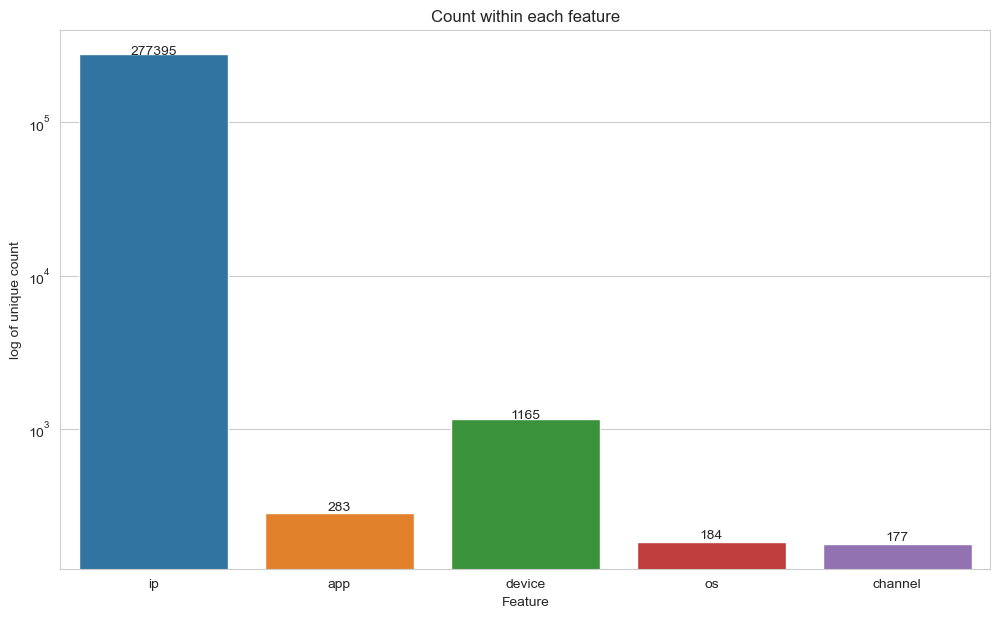

15

In [91]:
col = ['ip','app','device','os','channel']
cnt = [len(df[i].unique()) for i in col]

## Plotting on Barchart !

plt.figure(figsize=(12,7))
ax=sns.barplot(x=col, y=cnt, log= True)
ax.set(xlabel='Feature', ylabel='log of unique count',title="Count within each feature")
for p, uni in zip(ax.patches, cnt):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uni,
            ha="center")
plt.show()


del col
del cnt

gc.collect()

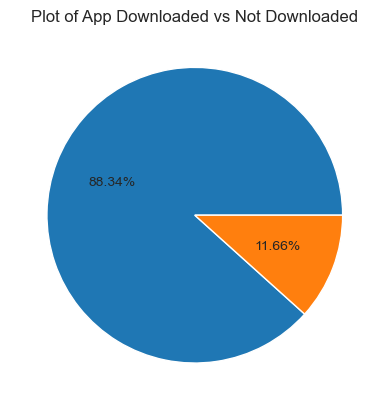

In [92]:
plt.pie(df['is_attributed'].value_counts(normalize=True)*100,autopct='%1.2f%%')
plt.title("Plot of App Downloaded vs Not Downloaded")
plt.show()

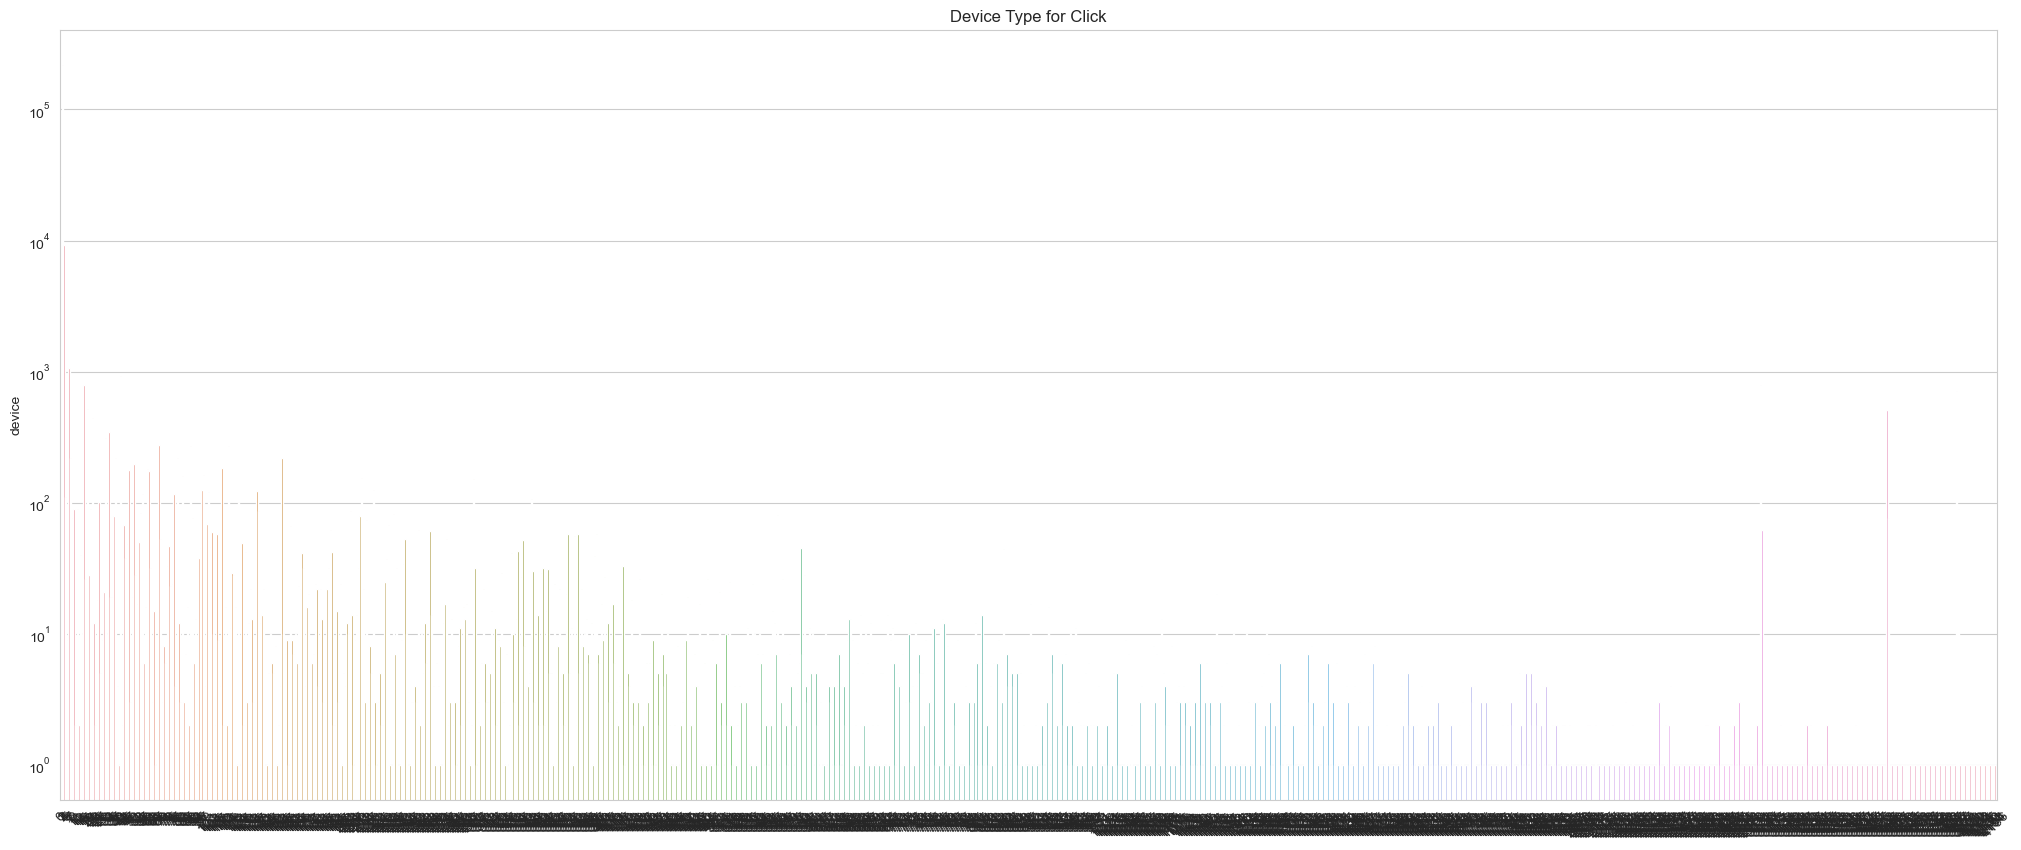

In [93]:
plt.figure(figsize=(25,10))
sns.barplot(x=df['device'].value_counts().index,y=df['device'].value_counts(), log=True)
plt.xticks(rotation=45)
plt.title("Device Type for Click")
plt.show()

240676

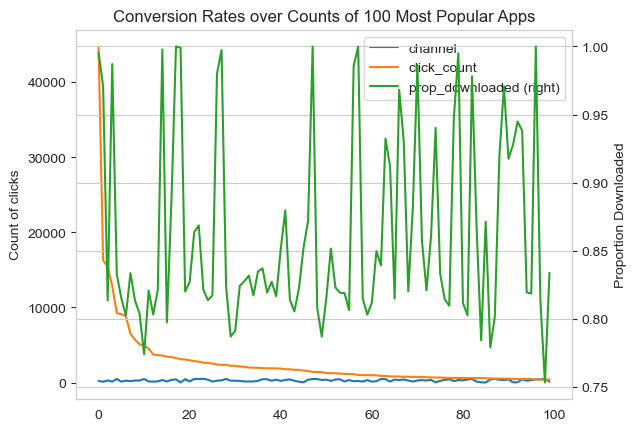

In [94]:
proportion = df[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = df[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']
ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.plot()



del proportion
del counts
del merge
del ax

gc.collect()

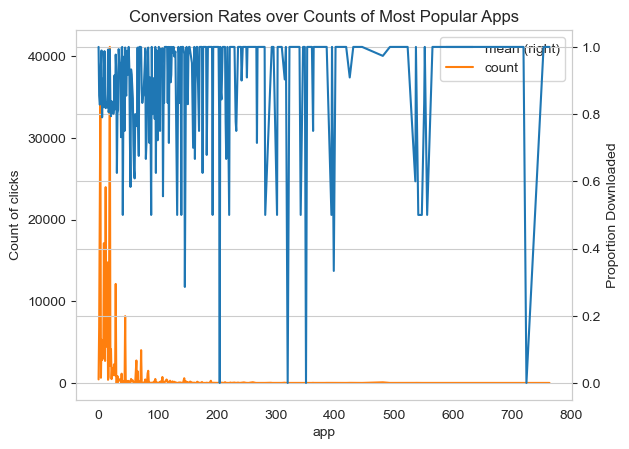

11311

In [95]:
app_target = df.groupby('app').is_attributed.agg(['mean', 'count'])
ax = app_target.plot(secondary_y='mean')
plt.title('Conversion Rates over Counts of Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()


del app_target
del ax

gc.collect()

# Feature Engineering

In [96]:
col = ['ip','app','device','os','channel']
for i in col:
    df[i]=df[i].astype('category')

In [97]:
df['click_time']=pd.to_datetime(df['click_time'])
df['attributed_time']=pd.to_datetime(df['attributed_time'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277395 entries, 0 to 277394
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ip               277395 non-null  category      
 1   app              277395 non-null  category      
 2   device           277395 non-null  category      
 3   os               277395 non-null  category      
 4   channel          277395 non-null  category      
 5   click_time       277395 non-null  datetime64[ns]
 6   attributed_time  277395 non-null  datetime64[ns]
 7   is_attributed    277395 non-null  uint16        
 8   ip_count         277395 non-null  uint16        
dtypes: category(5), datetime64[ns](2), uint16(2)
memory usage: 18.7 MB


In [98]:
df["datetime"]=pd.to_datetime(df["click_time"])
df["day_of_week"]=df["datetime"].dt.dayofweek
df["day_of_year"]=df["datetime"].dt.dayofyear
df["month"]=df["datetime"].dt.month
df["hour"]=df["datetime"].dt.hour

In [99]:
df['ip']=df['ip'].astype(np.int16)
df['app']=df['app'].astype(np.int16)
df['device']=df['device'].astype(np.int16)
df['os']=df['os'].astype(np.int16)
df['channel']=df['channel'].astype(np.int16)

In [101]:
df=df.drop(["click_time","datetime","attributed_time"], axis=1)

<Figure size 640x480 with 0 Axes>

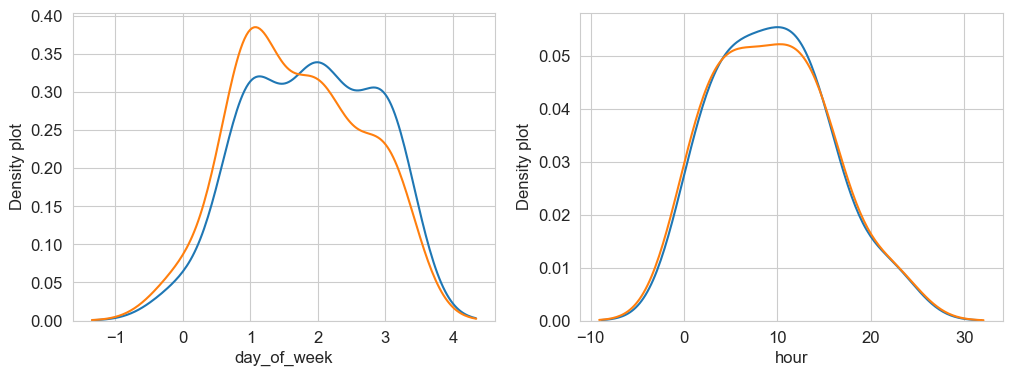

In [102]:
var = ['day_of_week','hour']

i = 0
t1 = df.loc[df['is_attributed'] != 0]
t0 = df.loc[df['is_attributed'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(12,4))

for feature in var:
    i += 1
    plt.subplot(1,2,i)
    sns.kdeplot(t1[feature], bw_method=0.5,label="is_attributed = 1")
    sns.kdeplot(t0[feature], bw_method=0.5,label="is_attributed = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

# Train-Test Split

In [103]:
X=df.drop("is_attributed",axis=1)
Y=df[["is_attributed"]]

In [104]:
x1,x2,y1,y2=train_test_split(X,Y,
                             test_size=0.25)
x1.shape, x2.shape, y1.shape, y2.shape

((208046, 10), (69349, 10), (208046, 1), (69349, 1))

# Modelling

# AdaBoost

In [51]:
#BAse Estimator
tree = DecisionTreeClassifier(max_depth=2)

#Adaboost using base estimator - tree

ada_model =  AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")

ada_model.fit(x1,y1.values.ravel())

y_pred = ada_model.predict_proba(x2)

y_pred[:10]

KeyboardInterrupt: 

In [67]:
ROC_Score = metrics.roc_auc_score(y2,y_pred[:,1])
print("ROC Score of AdaBoost Model:%.2f%%" % (ROC_Score * 100.0) )

ROC Score of AdaBoost Model:73.71%


In [ ]:
parameter = {"base_estimator__max_depth":[2,3],
            "n_estimators":[100,300,500]}

tree= DecisionTreeClassifier()

adaboostmodel = AdaBoostClassifier(base_estimator=tree,
                               learning_rate=0.9,
                                  algorithm="SAMME")

fold=3

grid_search_cv = GridSearchCV(adaboostmodel,
                             cv=fold,
                             param_grid=parameter,
                             scoring='roc_auc',
                             return_train_score=True,
                             verbose=1)
grid_search_cv.fit(x1,y1.values.ravel())

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [25]:
ada_cv_result = pd.DataFrame(grid_search_cv.cv_results_)
ada_cv_result = ada_cv_result[['rank_test_score','mean_test_score','mean_train_score',
                               'params', 'param_base_estimator__max_depth', 'param_n_estimators']]
ada_cv_result.sort_values(by='rank_test_score', inplace=True)
ada_cv_result

NameError: name 'grid_search_cv' is not defined

In [ ]:
tree = DecisionTreeClassifier(max_depth=2)

ada_model1 = AdaBoostClassifier(base_estimator=tree,learning_rate=0.5,n_estimators=300,algorithm="SAMME")

ada_model1.fit(x1,y1.values.ravel())
y_pred1 = ada_model1.predict_proba(x2)

ROC_Score=metrics.roc_auc_score(y2,y_pred1[:,1])
print("ROC Score of Hyperparameter Tunned AdaBoost Model:%.2f%%" % (ROC_Score * 100.0) )

# LightGBM

In [64]:
#Create a simple Light GBM Model and evaluate performance
train_data = lightgbm.Dataset(x1, label=y1)
valid_data = lightgbm.Dataset(x2, label=y2)

In [65]:
#Specify the parameters for LightGBM
parameters = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': 'true',
              'boosting': 'gbdt',
              'num_leaves': 105,
              'feature_fraction': 0.8,
              'bagging_fraction': 0.8,
              'bagging_freq': 1,
              'learning_rate': 0.08,
              'verbose': 1
             }

In [66]:
model_lgbm = lightgbm.train(parameters,
                            train_data,
                            valid_sets=valid_data,
                            num_boost_round=2500,
                            early_stopping_rounds=50)

C:\Users\jashraf\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 183783, number of negative: 24263
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1240
[LightGBM] [Info] Number of data points in the train set: 208046, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.883377 -> initscore=2.024803
[LightGBM] [Info] Start training from score 2.024803
[1]	valid_0's auc: 0.726027
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.799161
[3]	valid_0's auc: 0.797837
[4]	valid_0's auc: 0.804603
[5]	valid_0's auc: 0.806253
[6]	valid_0's auc: 0.806989
[7]	valid_0's auc: 0.808361
[8]	valid_0's auc: 0.808808
[9]	valid_0's auc: 0.809414
[10]	valid_0's auc: 0.809477
[11]	valid_0's auc: 0.809418
[12]	valid_0's auc: 0.809964
[13]	valid_0's auc: 0.810155
[14]	valid_0's auc: 0.810411
[15]	valid_0's auc: 0.810574
[16]	valid_0's au

In [67]:
y_train_pred = model_lgbm.predict(x1)
y_valid_pred = model_lgbm.predict(x2)

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y1, y_train_pred),
                                                    roc_auc_score(y2, y_valid_pred)))

AUC Train: 0.8349
AUC Valid: 0.8137


# XGBoost

In [62]:
XGB_model = XGBClassifier()
XGB_model.fit(x1,y1.values.ravel())

y_pred3 =XGB_model.predict_proba(x2)
y_pred3[:10]

C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:48:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([[1.9465685e-03, 9.9805343e-01],
       [1.2211025e-02, 9.8778898e-01],
       [1.8021941e-01, 8.1978059e-01],
       [1.8308687e-01, 8.1691313e-01],
       [1.5231025e-01, 8.4768975e-01],
       [2.2214651e-04, 9.9977785e-01],
       [2.4283528e-03, 9.9757165e-01],
       [1.7336577e-01, 8.2663423e-01],
       [3.3271992e-01, 6.6728008e-01],
       [2.3510629e-01, 7.6489371e-01]], dtype=float32)

In [63]:
ROC_Score=metrics.roc_auc_score(y2,y_pred3[:,1])
print("ROC Score of XGBoost Model :%.2f%%" % (ROC_Score * 100.0) )

ROC Score of XGBoost Model :81.15%


# Hyper-Parameter Tuning

In [64]:
fold = 3

parameter = {"learning_rate":[0.1,0.3,0.5],
            "subsample":[0.3,0.6,0.8],
            "n_estimators":[100,200,300,500],
            "max_depth":[2,3,4]}

xgb_model = XGBClassifier()

grid_xgb_model = GridSearchCV(xgb_model,
                             param_grid=parameter,
                             cv=fold,
                             scoring="roc_auc",return_train_score=True,
                             verbose=0)

grid_xgb_model.fit(x1,y1.values.ravel())

C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:49:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:49:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:49:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:49:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:49:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:49:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:49:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:49:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:50:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:50:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:50:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:50:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:50:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:50:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:51:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:51:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:51:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:51:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:51:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:52:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:52:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:52:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:53:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:53:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:53:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:54:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:54:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:54:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:55:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:55:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:56:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:56:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:57:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:57:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:58:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:58:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:59:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:59:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:59:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:59:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:59:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:59:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:59:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:00:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:00:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:00:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:00:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:00:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:00:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:01:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:01:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:01:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:01:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:02:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:02:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:02:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:03:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:03:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:03:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:04:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:04:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:05:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:05:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:05:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:06:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:07:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:07:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:08:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:09:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:09:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:10:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:11:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:11:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:11:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:12:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:12:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:12:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:12:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:12:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:12:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:13:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:13:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:13:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:13:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:14:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:14:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:14:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:15:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:15:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:15:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:16:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:16:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:16:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:17:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:17:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:18:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:18:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:19:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:19:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:20:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:20:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:21:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:21:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:22:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:23:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:24:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:24:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:25:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:26:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:26:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:26:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:26:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:26:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:27:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:27:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:27:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:27:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:27:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:27:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:27:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:28:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:28:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:28:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:28:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:28:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:29:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:29:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:29:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:29:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:30:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:30:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:30:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:31:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:31:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:31:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:31:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:32:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:32:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:33:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:33:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:34:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:34:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:34:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:35:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:35:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:35:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:36:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:36:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:36:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:36:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:36:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:36:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:36:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:36:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:37:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:37:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:37:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:37:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:38:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:38:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:38:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:38:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:39:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:39:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:39:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:40:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:40:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:40:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:41:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:41:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:41:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:42:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:42:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:43:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:43:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:44:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:45:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:45:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:46:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:46:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:47:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:47:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:47:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:47:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:48:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:48:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:48:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:48:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:48:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:48:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:49:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:49:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:49:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:49:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:50:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:50:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:50:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:51:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:51:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:51:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:52:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:52:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:53:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:53:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:53:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:54:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:54:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:55:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:56:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:56:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:57:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:58:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:58:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:59:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:00:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:01:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:02:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:02:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:02:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:02:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:02:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:02:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:02:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:02:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:02:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:03:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:03:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:03:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:03:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:03:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:04:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:04:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:04:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:04:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:04:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:05:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:05:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:05:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:05:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:06:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:06:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:06:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:07:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:07:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:07:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:08:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:08:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:09:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:09:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:09:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:10:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:10:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:11:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:11:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:11:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:11:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:11:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:12:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:12:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:12:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:12:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:12:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:12:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:12:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:13:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:13:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:13:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:14:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:14:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:14:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:14:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:15:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:15:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:15:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:16:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:16:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:16:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:17:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:17:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:17:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:18:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:18:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:19:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:19:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:20:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:21:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:21:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:22:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:23:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:23:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:23:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:23:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:23:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:23:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:23:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:24:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:24:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:24:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:24:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:24:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:25:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:25:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:25:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:26:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:26:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:26:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:26:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:27:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:27:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:28:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:28:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:29:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:29:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:30:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:30:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:31:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:31:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:32:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:33:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:33:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:34:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:35:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:36:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:37:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:37:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [65]:
cv_results = pd.DataFrame(grid_xgb_model.cv_results_)
cv_results = cv_results[['rank_test_score','mean_test_score','mean_train_score',
                               'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
cv_results.sort_values(by='rank_test_score', inplace=True)
cv_results


,rank_test_score,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators
32,1,0.811343,0.832654,0.1,4,300
35,2,0.811219,0.845238,0.1,4,500
29,3,0.810712,0.824995,0.1,4,200
31,4,0.810453,0.832234,0.1,4,300
23,5,0.810204,0.827053,0.1,3,500
...,...,...,...,...,...,...
1,104,0.789674,0.791339,0.1,2,100
0,105,0.789607,0.790921,0.1,2,100
2,106,0.789173,0.790996,0.1,2,100
102,107,0.786714,0.844371,0.5,4,300


Text(0.5, 1.0, 'Performance with respect to the number of Trees and Depth')

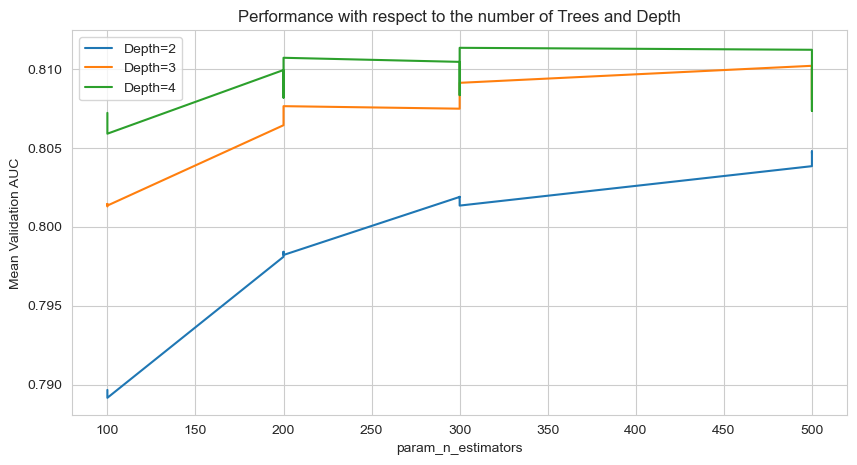

In [74]:
# First sort by number of estimators as that would be x-axis
cv_results.sort_values(by='param_n_estimators', inplace=True)

# Find values of AUC for learning rate of 0.05 and different values of depth
lr_d2 = cv_results.loc[(cv_results['param_learning_rate']==0.1) & (cv_results['param_max_depth']==2),:]
lr_d3 = cv_results.loc[(cv_results['param_learning_rate']==0.1) & (cv_results['param_max_depth']==3),:]
lr_d4 = cv_results.loc[(cv_results['param_learning_rate']==0.1) & (cv_results['param_max_depth']==4),:]
#lr_d5 = cv_results.loc[(cv_results['param_learning_rate']==0.05) & (cv_results['param_max_depth']==5),:]

# Let us plot now
fig, ax = plt.subplots(figsize=(10,5))
lr_d2.plot(x='param_n_estimators', y='mean_test_score', label='Depth=2', ax=ax)
lr_d3.plot(x='param_n_estimators', y='mean_test_score', label='Depth=3', ax=ax)
lr_d4.plot(x='param_n_estimators', y='mean_test_score', label='Depth=4', ax=ax)
#lr_d5.plot(x='param_n_estimators', y='mean_test_score', label='Depth=5', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance with respect to the number of Trees and Depth')

Text(0.5, 1.0, 'Performance with respect to the learning rate')

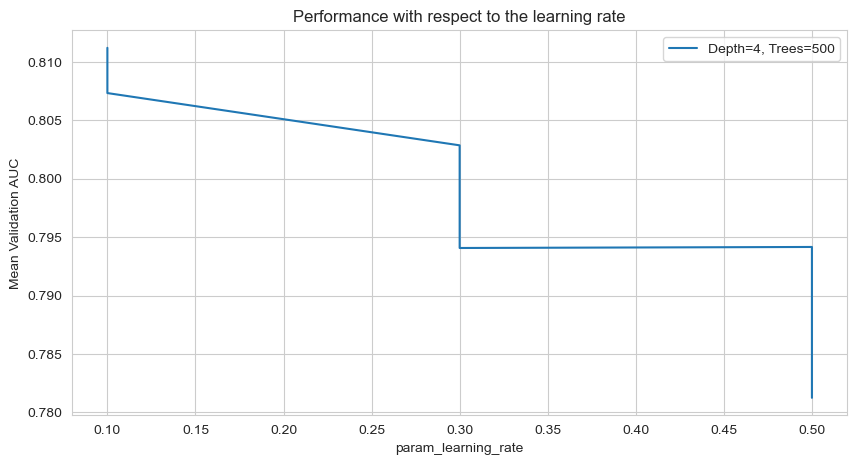

In [75]:
# First sort by learning rate as that would be x-axis
cv_results.sort_values(by='param_learning_rate', inplace=True)

# Find values of AUC for learning rate of 0.05 and different values of depth
lr_t3k_d2 = cv_results.loc[(cv_results['param_n_estimators']==500) & (cv_results['param_max_depth']==4),:]

# Let us plot now
fig, ax = plt.subplots(figsize=(10,5))
lr_t3k_d2.plot(x='param_learning_rate', y='mean_test_score', label='Depth=4, Trees=500', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance with respect to the learning rate')

# Final Model

In [105]:
XGBC_model = XGBClassifier(max_depth=4,
                                       n_estimators=500,
                                       learning_rate=0.1,
                                       eval_metric='auc',
                                       subsample=1)
eval_set = [(x1, y1),(x2, y2)]
XGBC_model.fit(x1,
               y1.values.ravel(),
              eval_set=eval_set)
y_pred4=XGBC_model.predict_proba(x2)
y_pred4[:10]

C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jashraf\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\jashraf\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, 

[0]	validation_0-auc:0.77076	validation_1-auc:0.77223
[1]	validation_0-auc:0.77751	validation_1-auc:0.77839
[2]	validation_0-auc:0.77788	validation_1-auc:0.77911
[3]	validation_0-auc:0.77928	validation_1-auc:0.78067
[4]	validation_0-auc:0.77995	validation_1-auc:0.78108
[5]	validation_0-auc:0.77967	validation_1-auc:0.78052
[6]	validation_0-auc:0.78047	validation_1-auc:0.78118
[7]	validation_0-auc:0.78167	validation_1-auc:0.78248
[8]	validation_0-auc:0.78263	validation_1-auc:0.78349
[9]	validation_0-auc:0.78299	validation_1-auc:0.78395
[10]	validation_0-auc:0.78326	validation_1-auc:0.78425
[11]	validation_0-auc:0.78406	validation_1-auc:0.78497
[12]	validation_0-auc:0.78558	validation_1-auc:0.78681
[13]	validation_0-auc:0.78596	validation_1-auc:0.78726
[14]	validation_0-auc:0.78553	validation_1-auc:0.78700
[15]	validation_0-auc:0.78697	validation_1-auc:0.78837
[16]	validation_0-auc:0.78733	validation_1-auc:0.78854
[17]	validation_0-auc:0.78812	validation_1-auc:0.78957
[18]	validation_0-au

[149]	validation_0-auc:0.81539	validation_1-auc:0.81212
[150]	validation_0-auc:0.81547	validation_1-auc:0.81221
[151]	validation_0-auc:0.81550	validation_1-auc:0.81222
[152]	validation_0-auc:0.81560	validation_1-auc:0.81225
[153]	validation_0-auc:0.81561	validation_1-auc:0.81225
[154]	validation_0-auc:0.81566	validation_1-auc:0.81226
[155]	validation_0-auc:0.81571	validation_1-auc:0.81229
[156]	validation_0-auc:0.81575	validation_1-auc:0.81229
[157]	validation_0-auc:0.81587	validation_1-auc:0.81235
[158]	validation_0-auc:0.81588	validation_1-auc:0.81236
[159]	validation_0-auc:0.81592	validation_1-auc:0.81234
[160]	validation_0-auc:0.81613	validation_1-auc:0.81244
[161]	validation_0-auc:0.81619	validation_1-auc:0.81244
[162]	validation_0-auc:0.81628	validation_1-auc:0.81251
[163]	validation_0-auc:0.81634	validation_1-auc:0.81251
[164]	validation_0-auc:0.81636	validation_1-auc:0.81251
[165]	validation_0-auc:0.81656	validation_1-auc:0.81269
[166]	validation_0-auc:0.81659	validation_1-auc:

[296]	validation_0-auc:0.82476	validation_1-auc:0.81524
[297]	validation_0-auc:0.82480	validation_1-auc:0.81526
[298]	validation_0-auc:0.82486	validation_1-auc:0.81529
[299]	validation_0-auc:0.82493	validation_1-auc:0.81528
[300]	validation_0-auc:0.82496	validation_1-auc:0.81526
[301]	validation_0-auc:0.82496	validation_1-auc:0.81526
[302]	validation_0-auc:0.82497	validation_1-auc:0.81525
[303]	validation_0-auc:0.82500	validation_1-auc:0.81524
[304]	validation_0-auc:0.82500	validation_1-auc:0.81523
[305]	validation_0-auc:0.82505	validation_1-auc:0.81521
[306]	validation_0-auc:0.82508	validation_1-auc:0.81519
[307]	validation_0-auc:0.82512	validation_1-auc:0.81519
[308]	validation_0-auc:0.82517	validation_1-auc:0.81521
[309]	validation_0-auc:0.82529	validation_1-auc:0.81528
[310]	validation_0-auc:0.82532	validation_1-auc:0.81529
[311]	validation_0-auc:0.82537	validation_1-auc:0.81531
[312]	validation_0-auc:0.82542	validation_1-auc:0.81529
[313]	validation_0-auc:0.82546	validation_1-auc:

[443]	validation_0-auc:0.83142	validation_1-auc:0.81621
[444]	validation_0-auc:0.83147	validation_1-auc:0.81620
[445]	validation_0-auc:0.83153	validation_1-auc:0.81619
[446]	validation_0-auc:0.83159	validation_1-auc:0.81619
[447]	validation_0-auc:0.83163	validation_1-auc:0.81620
[448]	validation_0-auc:0.83168	validation_1-auc:0.81619
[449]	validation_0-auc:0.83173	validation_1-auc:0.81618
[450]	validation_0-auc:0.83177	validation_1-auc:0.81619
[451]	validation_0-auc:0.83185	validation_1-auc:0.81621
[452]	validation_0-auc:0.83185	validation_1-auc:0.81621
[453]	validation_0-auc:0.83188	validation_1-auc:0.81621
[454]	validation_0-auc:0.83193	validation_1-auc:0.81618
[455]	validation_0-auc:0.83202	validation_1-auc:0.81624
[456]	validation_0-auc:0.83206	validation_1-auc:0.81624
[457]	validation_0-auc:0.83208	validation_1-auc:0.81622
[458]	validation_0-auc:0.83211	validation_1-auc:0.81624
[459]	validation_0-auc:0.83215	validation_1-auc:0.81623
[460]	validation_0-auc:0.83220	validation_1-auc:

array([[0.08248597, 0.917514  ],
       [0.00438762, 0.9956124 ],
       [0.14550269, 0.8544973 ],
       [0.00148135, 0.99851865],
       [0.02161086, 0.97838914],
       [0.14387691, 0.8561231 ],
       [0.00251496, 0.99748504],
       [0.25370157, 0.74629843],
       [0.00525123, 0.9947488 ],
       [0.00176525, 0.99823475]], dtype=float32)

In [106]:
ROC_Score=metrics.roc_auc_score(y2,y_pred4[:,1])
print("ROC Score of Hyperparameter Tunned XGBoost Model :%.2f%%" % (ROC_Score * 100.0) )

ROC Score of Hyperparameter Tunned XGBoost Model :81.64%


In [107]:
y_train_pred = XGBC_model.predict_proba(x1)[:,1]
y_valid_pred = XGBC_model.predict_proba(x2)[:,1]

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y1, y_train_pred),
                                                    roc_auc_score(y2, y_valid_pred)))

AUC Train: 0.8335
AUC Valid: 0.8164


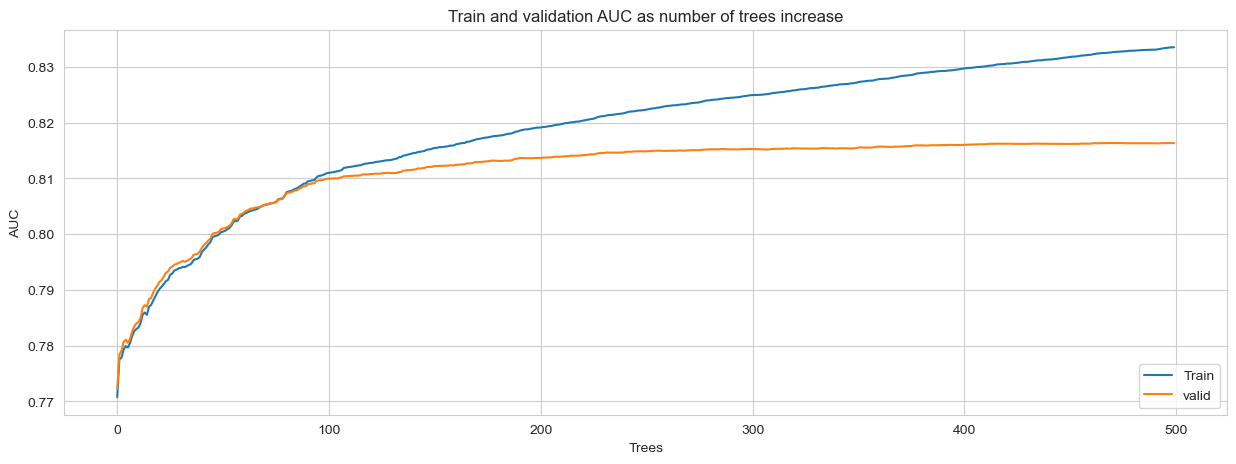

In [108]:
evaluation_results = XGBC_model.evals_result()

# Index into each key to find AUC values for training and validation data after each tree
train_auc_tree = evaluation_results['validation_0']['auc']
valid_auc_tree = evaluation_results['validation_1']['auc']


# Plotting Section
plt.figure(figsize=(15,5))

plt.plot(train_auc_tree, label='Train')
plt.plot(valid_auc_tree, label='valid')

plt.title("Train and validation AUC as number of trees increase")
plt.xlabel("Trees")
plt.ylabel("AUC")
plt.legend(loc='lower right')
plt.show()

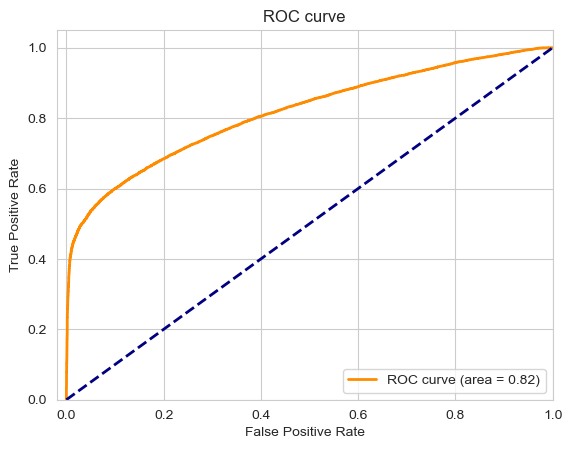

In [111]:
from sklearn.metrics import roc_curve, auc
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y2.values, y_pred4[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

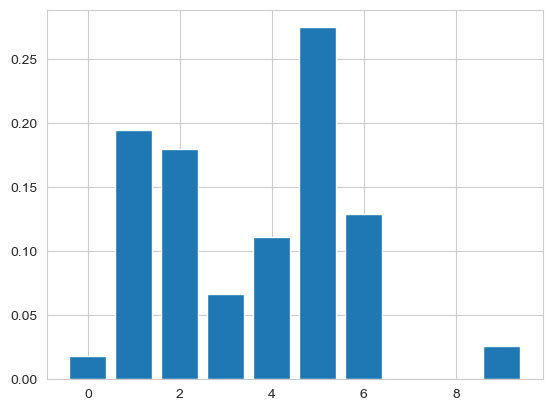

In [80]:
plt.bar(range(len(XGBC_model.feature_importances_)), XGBC_model.feature_importances_)
plt.show()

# Feature importance

In [112]:
# feature importance
importance = dict(zip(x1.columns, XGBC_model.feature_importances_))
importance

{'ip': 0.018354679,
 'app': 0.18496743,
 'device': 0.20198646,
 'os': 0.064349,
 'channel': 0.10275661,
 'ip_count': 0.27163517,
 'day_of_week': 0.13310274,
 'day_of_year': 0.0,
 'month': 0.0,
 'hour': 0.022847865}

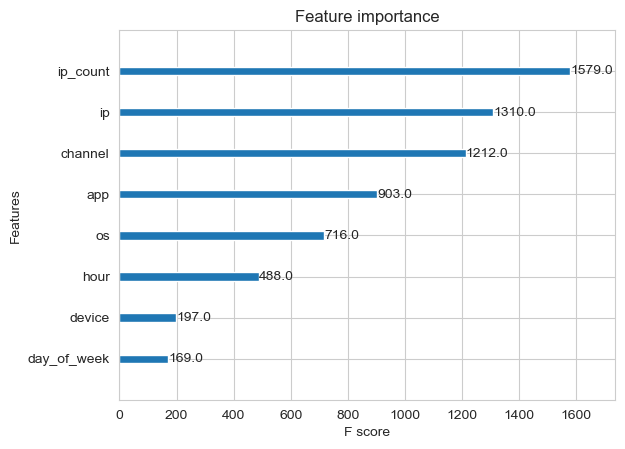

In [113]:

from matplotlib import pyplot

# plot feature importance


plot_importance(XGBC_model)
pyplot.show()

In [114]:
importance = dict(zip(x1.columns, XGBC_model.feature_importances_))
importance

{'ip': 0.018354679,
 'app': 0.18496743,
 'device': 0.20198646,
 'os': 0.064349,
 'channel': 0.10275661,
 'ip_count': 0.27163517,
 'day_of_week': 0.13310274,
 'day_of_year': 0.0,
 'month': 0.0,
 'hour': 0.022847865}

# Prediction

In [117]:
y_predicted = XGBC_model.predict(x2)

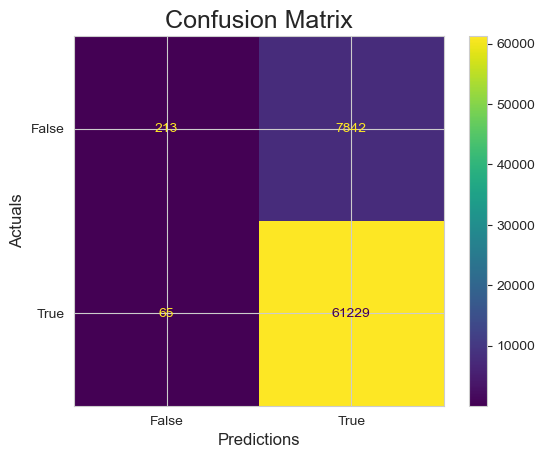

In [122]:
#confusion matrix
from sklearn.metrics import confusion_matrix, classification_report





actual = np.random.binomial(1,.9,size = 1000)
predicted = np.random.binomial(1,.9,size = 1000)

confusion_matrix = confusion_matrix(y2,y_predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [129]:
print("Precision score: %.3f"%precision_score(y2,y_predicted))
print("Recall score: %.3f"%recall_score(y2,y_predicted))
print("F1 Score: %.3f" %f1_score(y2,y_predicted))
print('Accuracy: %.3f' % accuracy_score(y2, y_predicted))

Precision score: 0.886
Recall score: 0.999
F1 Score: 0.939
Accuracy: 0.886


In [123]:
print(classification_report(y2,y_predicted))

              precision    recall  f1-score   support

           0       0.77      0.03      0.05      8055
           1       0.89      1.00      0.94     61294

    accuracy                           0.89     69349
   macro avg       0.83      0.51      0.50     69349
weighted avg       0.87      0.89      0.84     69349

